In [1]:
import warnings ; warnings.filterwarnings('ignore')

In [2]:
import h5py, time, pickle, pandas, random, os
from scipy.stats.mstats import zscore
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import colour 
import pandas as pd 
import matplotlib.patheffects as pe
import statsmodels.formula.api as sm
from IPython.display import Markdown as md
import colour 
from scipy import stats

In [3]:
_location = '/Users/biota/work/perirhinal_cortex/communication/figures/'

In [4]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [5]:
def sigfigs(x): 
    # decimal places
    d = int(str('%.2e'%x)[('%.2e'%x).find('-')+1:])
    # the numeric value in front of it
    n = np.round(float(str('%.02e'%x)[0:3]))
    return n, d

def show_model_parameters(model_, index_ =-1): 
    
    beta = model_.params[index_]
    pval = model_.pvalues[index_]
    rsqrd= model_.rsquared
    df_model = model_.df_model
    df_resid = model_.df_resid
    tvalues = model_.tvalues[index_]
    
    if pval < .05: 
        _nums = sigfigs(pval)
        if _nums[1] > 2: 
            stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p < %.0f $ x $ 10 ^{-%d} $"
            report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, _nums[0], _nums[1])
        else: 
            stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p < .05 $"
            report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues)
    else: 
        stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p > .05$"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues) 
    
    return md(report), report

In [6]:
def sigfigs(x): 
    # decimal places
    d = int(str('%.2e'%x)[('%.2e'%x).find('-')+1:])
    # the numeric value in front of it
    n = np.ceil(float(str('%.02e'%x)[0:3]))
    return n, d

def show_model_parameters(model_, index_ =-1): 
    
    beta = model_.params[index_]
    pval = model_.pvalues[index_]
    rsqrd= model_.rsquared
    df_model = model_.df_model
    df_resid = model_.df_resid
    tvalues = model_.tvalues[index_]
    
    print(pval)
    
    if pval < .05: 
        _nums = sigfigs(pval)
        if _nums[1] > 2: 
            stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p < %.0f $ x $ 10 ^{-%d} $"
            report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues, _nums[0], _nums[1])
        else: 
            stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p < .05 $"
            report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues)
    else: 
        
        stat_str = "$R^{2}_{model} = %.02f$, $\\beta = %.2f$, $F(%d, %d)$ = $%.02f, p > .05$"
        report = stat_str%(rsqrd, beta, df_model, df_resid, tvalues) 
    
    return md(report), report

In [7]:
def get_neural_reliability(): 
    
    ventral_neural_data_path = '/Users/biota/work/perirhinal_cortex/analysis/yamins_2014/ventral_neural_data.hdf5'
    data = h5py.File(ventral_neural_data_path, 'r')

    # extract all trials for each time averaged neuron 
    trials = {i: data['time_averaged'][i] for i in data['time_averaged'] if '3' in i }

    #print('including', list(trials))

    regions = ['IT_NEURONS', 'V4_NEURONS']
    reliability = {r:[] for r in regions}
    n_permutations = 10 

    for i_permutation in range(n_permutations): 

        # generate a random split and order it in a way that will be easy to index 
        rndm_ = {i: np.random.permutation(trials[i].shape[0]) for i in trials}
        rndm = {i: (rndm_[i][:len(rndm_[i])//2], rndm_[i][len(rndm_[i])//2:]) for i in trials}

        # iterate over regions 
        for i_region in regions: 

            region = {i: trials[i][:, :, data['neural_meta'][i_region]] for i in trials}

            # iterate over neurons 
            for i_neuron in range(region[list(region)[0]].shape[2]): 

                # extract neuron's responses
                a = np.concatenate([region[i][rndm[i][0],:,i_neuron].mean(0) for i in trials], 0)
                # split neuron's responses into two halves and find the mean across trials 
                b = np.concatenate([region[i][rndm[i][1],:,i_neuron].mean(0) for i in trials], 0)

                # compute the correlation between each half across all images
                neuron_split_reliability = np.corrcoef(a, b)
                # store the off diagonal
                reliability[i_region].append(neuron_split_reliability[0, 1]) 

    data.close()
    
    return reliability
    
def get_pls_layer_fits(reliability): 
        
    measure = lambda x : np.median(x)
    sqrt = lambda x : np.sqrt(x)
    
    layers = {} 
    data_path = '/Users/biota/work/perirhinal_cortex/analysis/yamins_2014/model_neural_fits/'
    for i in [i for i in os.listdir(data_path) if '_5-' in i and 'V3' in i]: 
        with open(os.path.join(data_path, i), 'rb') as handle: 
            layers[ i[:i.find('-')] ] = pickle.load(handle)
        
    order=['pool1', 
           'conv2_1', 'conv2_2',
           'pool2',
           'conv3_1','conv3_2','conv3_3',
           'pool3',
           'conv4_1','conv4_2','conv4_3','pool4',
           'conv5_1','conv5_2','conv5_3','pool5',
           'fc6','fc7','fc8']

    n_layers = len(order)
    it_noise = measure(reliability['IT_NEURONS'])
    v4_noise = measure(reliability['V4_NEURONS'])

    delta = [] 
    it_std = []
    v4_std = [] 
    it_fits = [] 
    v4_fits = [] 
    delta_std = [] 
    DELTA = {} 

    for i in order: 

        it_ = layers[i]['it_test']
        v4_ = layers[i]['v4_test'] 
        n_it = len(layers[i]['it_test'][0])
        n_v4 = len(layers[i]['v4_test'][0])

        it_m = measure(it_)  / it_noise
        it_s =  np.std(it_)  / sqrt( len(it_) )
        v4_m = measure(v4_)  / v4_noise 
        v4_s = np.std( v4_ ) / sqrt( len(v4_) ) 
        
        # delta it-v4
        d_ = it_m - v4_m

        it_fits.append(  it_m ) 
        it_std.append( it_s ) 
        v4_fits.append( v4_m ) 
        v4_std.append( v4_s ) 

        delta.append( d_ )
        delta_std.append( (it_s + v4_s)/ 2 )

        DELTA[i] = {'mu': d_.round(2), 'std':((it_s + v4_s)/ 2).round(2) }

    it_fits=np.array(it_fits)
    it_std=np.array(it_std)
    v4_fits=np.array(v4_fits)
    v4_std=np.array(v4_std)
    delta = np.array(delta)
    delta_std = np.array(delta_std)

    it_color = '#fa7e1e'#'#FF9300'
    v4_color = '#962fbf'#'#932191'
    delta_color = '#545454'# '#C7594B'# '#d62976'

    plt.figure(figsize=[16,4])
    plt.subplot(131)

    n_bins = 20
    plt.hist( reliability['IT_NEURONS'], color=it_color, alpha=.1, bins=n_bins)
    plt.hist( reliability['V4_NEURONS'], color=v4_color, alpha=.1, bins=n_bins)
    plt.hist( reliability['IT_NEURONS'], color=it_color, histtype='step', linewidth=2, bins=n_bins)
    plt.hist( reliability['V4_NEURONS'], color=v4_color, histtype='step', linewidth=2, bins=n_bins)
    it_mean, v4_mean = measure( reliability['IT_NEURONS']), measure( reliability['V4_NEURONS'])

    plt.scatter([], [], s=100, marker=',', color=it_color, label=r'$\bar{IT}$: %.02f'%it_mean, alpha=1)
    plt.scatter([], [], s=100, marker=',', color=v4_color, label=r'$\bar{V4}$: %.02f'%v4_mean, alpha=1)
    plt.legend(title='Region', framealpha=0, fontsize=12, title_fontsize=13) 

    plt.title('Distribution of single neuron reliability scores', fontsize=13, y=1.05); 


    plt.subplot(132)
    i_alpha=.15
    plt.plot( v4_fits, label='V4', color=v4_color, linestyle='-', linewidth=2) 
    plt.fill_between(x=range(len(order)), y1=v4_fits+v4_std, y2=v4_fits-v4_std, color=v4_color, alpha=i_alpha)
    
    plt.plot( it_fits, label='IT', color=it_color, linestyle='-', linewidth=2) 
    plt.fill_between(x=range(len(order)), y1=it_fits+it_std, y2=it_fits-it_std, color=it_color, alpha=i_alpha)
    plt.xticks(range(len(order)), ['$%s$'%i for i in order], rotation=90);
    plt.title('Model fit to neural region by layer', fontsize=15, y=1.05); 
    #plt.ylim([-.1, 1.2])
    plt.yticks(fontsize=9 ) 
    plt.ylabel('Correlation between neural-model predictions\n(corrected for noise ceiling)', labelpad=-2)
    plt.subplot(133)
    y_ =  delta

    plt.plot( y_, color=delta_color, linestyle='-', linewidth=2)
    plt.fill_between(x=range(n_layers), y1=y_, y2=np.zeros(n_layers), alpha=.1, color='grey', )

#    plt.fill_between(x=range(len(order)), y1=y_ - delta_std, y2=y_ + delta_std, color=delta_color, alpha=.2)
    #plt.ylim([-.6, .5])
    plt.title('Differential IT predictions', fontsize=15, y=1.05)
    plt.xticks(range(len(order)), ['$%s$'%i for i in order], rotation=90);
    #plt.yticks(np.arange(-.4, .5, .20) , np.arange(-.4, .5, .20).round(1) ) ; 
    #plt.ylabel('$\Delta_{IT-V4}$'); 
    
    plt.savefig('/Users/biota/Desktop/scratch/neural_reliability_prePLS.pdf', format='pdf', bbox_inches = "tight")
    data = {'it':{'mu':it_fits, 'std':it_std}, 
            'v4':{'mu':v4_fits, 'std':v4_std}, 
            'delta':{'mu':delta, 'std':delta_std}, 
            'layers': order}
    
    return data, DELTA

In [8]:
reliability = get_neural_reliability()

### median split-half reliability for IT

In [9]:
(r'$r=%.02f \pm %.02fSTD$'%(np.median(reliability['IT_NEURONS']), np.std(reliability['IT_NEURONS'])))

'$r=0.72 \\pm 0.24STD$'

### median split-half reliability for V4

In [10]:
(r'$r=%.02f \pm %.02fSTD$'%(np.median(reliability['V4_NEURONS']), np.std(reliability['V4_NEURONS'])))

'$r=0.62 \\pm 0.22STD$'

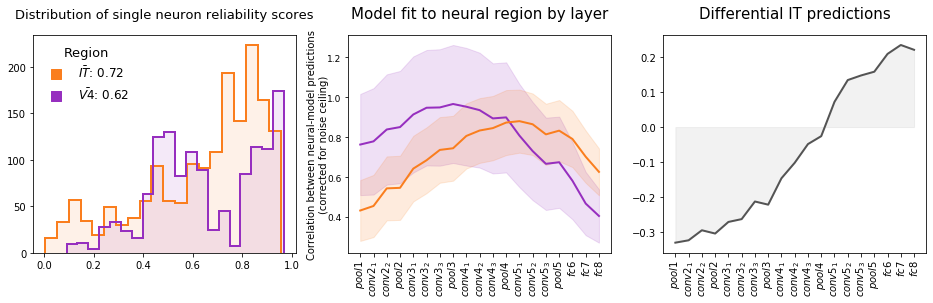

In [11]:
pls_fits, pls_delta = get_pls_layer_fits(reliability) 

### first half fits V4 better

In [12]:
_ttest_v4split = stats.ttest_ind(pls_fits['v4']['mu'][:len(pls_fits['it']['mu'])//2], # first half
                                 pls_fits['v4']['mu'][len(pls_fits['it']['mu'])//2:]) # second half 
md(r'$ t(%d)=%.02f, p < %.03f$'%(len(pls_fits['it']['mu'])//2-1, _ttest_v4split[0], _ttest_v4split[1]))

$ t(8)=2.70, p < 0.015$

### second half fits IT better

In [13]:
_ttest_itsplit = stats.ttest_ind(pls_fits['it']['mu'][len(pls_fits['it']['mu'])//2:], # second half 
                pls_fits['it']['mu'][:len(pls_fits['it']['mu'])//2]) # first half
md(r'$ t(%d)=%.02f, p < %.03f$'%(len(pls_fits['it']['mu'])//2-1, _ttest_itsplit[0], _ttest_itsplit[1]))

$ t(8)=3.70, p < 0.002$

In [14]:
_increasing_itfit = smf.ols('zscore(y)~zscore(x)', 
                            data=pandas.DataFrame({'y':[pls_delta[i]['mu'] for i in pls_delta], 
                                                   'x':np.arange(len(pls_delta))})).fit()
show_model_parameters(_increasing_itfit)[0]

1.0124407123307306e-13


$R^{2}_{model} = 0.96$, $\beta = 0.98$, $F(1, 17)$ = $21.37, p < 1 $ x $ 10 ^{-13} $

# metaparameters for analysis

In [15]:
('%s  'r'$r=%.02f \pm %.02fSTD$'%(list(pls_delta)[ pls_fits['it']['mu'].argmax() ] ,  
                                    pls_fits['it']['mu'].max(), 
                                    pls_fits['it']['std'][pls_fits['it']['mu'].argmax()]))

'conv5_1  $r=0.88 \\pm 0.16STD$'

In [16]:
('%s  'r'$r=%.02f \pm %.02fSTD$'%(list(pls_delta)[ pls_fits['v4']['mu'].argmax() ] ,  
                                    pls_fits['v4']['mu'].max(), 
                                    pls_fits['v4']['std'][pls_fits['v4']['mu'].argmax()]))

'pool3  $r=0.97 \\pm 0.30STD$'

### identify 'IT-like' and 'V4-like' layers 

In [17]:
it_layer = list(pls_delta)[ pls_fits['it']['mu'].argmax() ] 
v4_layer =  list(pls_delta)[ pls_fits['v4']['mu'].argmax() ] 

In [18]:
(np.array(list(pls_delta)) == 'conv5_1').argmax()

12

In [19]:
pls_fits['it']['mu'][(np.array(list(pls_delta)) == 'conv5_1').argmax()] # 0.877  0.0121

0.8801081799678573

In [20]:
pls_fits['it']['std'][(np.array(list(pls_delta)) == 'fc6').argmax()] # 0.788 0.01 # 0.877  0.0121

0.1411390595436822

# Diagnostic Experiments

In [21]:
import retrospective.combine_results as retrospective

In [22]:
base_directory = '/Users/biota/work/mtl_perception/retrospective/'

In [23]:
retrospective, retrospective_statistics  = retrospective.across_studies( it_layer, v4_layer, base_directory) 

In [37]:
layers = [ 'conv1_1', 'conv1_2', 'pool1', 'conv2_1', 'conv2_2', 'pool2', 
           'conv3_1', 'conv3_2', 'conv3_3','pool3', 'conv4_1', 'conv4_2', 'conv4_3', 'pool4',
           'conv5_1', 'conv5_2', 'conv5_3', 'pool5', 'fc6', 'fc7', 'fc8']


interactions = {'prc_con':[], 'hpc_con':[]}

prc_lesion = meta_df['prc_lesion'].values.astype('float64')
hpc_lesion = meta_df['hpc_lesion'].values.astype('float64')
prc_intact = meta_df['prc_intact'].values.astype('float64')
hpc_intact = meta_df['hpc_intact'].values.astype('float64') 

n_ = len(prc_lesion)
prc_lesion_rmse, hpc_lesion_rmse, prc_intact_rmse , hpc_intact_rmse = [] , [] , [] , [] 
r_squared = {'prc_lesion':[], 'prc_intact':[], 'hpc_lesion':[], 'hpc_intact':[]}

for i_layer in layers: 
    
    model_responses = np.array(meta_df[i_layer].values).astype('float64')
    
    # stats 
    prc_data = pandas.DataFrame(
        {'model': np.concatenate((model_responses, model_responses)), 
         'human': np.concatenate((prc_lesion, prc_intact)),
         'group': np.concatenate([np.repeat(0,n_), np.repeat(1, n_)])})

    prc_lesion_rmse_ = np.sqrt( np.mean( (np.array(prc_lesion) - np.array(model_responses) )**2 ) )
    hpc_lesion_rmse_ = np.sqrt( np.mean( (np.array(hpc_lesion) - np.array(model_responses) )**2 ) )
    prc_intact_rmse_ = np.sqrt( np.mean( (np.array(prc_intact) - np.array(model_responses) )**2 ) )
    hpc_intact_rmse_ = np.sqrt( np.mean( (np.array(hpc_intact) - np.array(model_responses) )**2 ) )

    prc_interaction = smf.ols("human ~ model * group", prc_data).fit()
    interactions['prc_con'].append( prc_interaction.pvalues[-1] )
    # stats 
    hpc_data = pandas.DataFrame(
        {'model': np.concatenate((model_responses, model_responses)), 
         'human': np.concatenate((hpc_lesion, hpc_intact)),
         'group': np.concatenate([np.repeat(0,n_), np.repeat(1, n_)])})


    hpc_interaction = smf.ols("human ~ model * group", hpc_data).fit().pvalues[-1]
    interactions['hpc_con'].append( hpc_interaction )    
    
    prc_lesion_rmse.append(prc_lesion_rmse_)
    hpc_lesion_rmse.append(hpc_lesion_rmse_)
    prc_intact_rmse.append(prc_intact_rmse_)
    hpc_intact_rmse.append(hpc_intact_rmse_)
    
prc_lesion_rmse = np.array(prc_lesion_rmse) 
prc_intact_rmse = np.array(prc_intact_rmse)
hpc_lesion_rmse = np.array(hpc_lesion_rmse) 
hpc_intact_rmse = np.array(hpc_intact_rmse) 

layer_data = pandas.DataFrame({'prc_interaction': interactions['prc_con'], 
                                 'hpc_interaction': interactions['hpc_con'], 
                                 'prc_lesion_rmse': prc_lesion_rmse, 
                                 'hpc_lesion_rmse': hpc_lesion_rmse, 
                                 'prc_intact_rmse': prc_intact_rmse, 
                                 'hpc_intact_rmse': hpc_intact_rmse, 
                                 'prc_delta_rmse': prc_intact_rmse-prc_lesion_rmse, 
                                 'hpc_delta_rmse': hpc_intact_rmse-hpc_lesion_rmse, 
                                 'layer': layers})

In [38]:
layer_data

,prc_interaction,hpc_interaction,prc_lesion_rmse,hpc_lesion_rmse,prc_intact_rmse,hpc_intact_rmse,prc_delta_rmse,hpc_delta_rmse,layer
0,0.026149,0.927562,0.305113,0.420150,0.430511,0.427732,0.125399,0.007583,conv1_1
1,0.160745,0.944024,0.321575,0.421471,0.430733,0.428723,0.109158,0.007252,conv1_2
2,0.014976,0.750431,0.279236,0.399028,0.412759,0.410310,0.133523,0.011282,pool1
3,0.005806,0.635468,0.283882,0.396495,0.410640,0.408984,0.126759,0.012489,conv2_1
4,0.039083,0.788127,0.313412,0.414737,0.425830,0.423892,0.112417,0.009155,conv2_2
5,0.016357,0.740806,0.295993,0.409398,0.422583,0.420095,0.126589,0.010697,pool2
6,0.032173,0.767648,0.284757,0.396184,0.409247,0.406678,0.124490,0.010494,conv3_1
7,0.044094,0.776899,0.300521,0.418324,0.432563,0.429610,0.132042,0.011286,conv3_2
8,0.027846,0.773751,0.278000,0.399257,0.413261,0.410492,0.135261,0.011236,conv3_3
9,0.014691,0.754898,0.278142,0.408787,0.423896,0.421073,0.145754,0.012286,pool3


In [83]:
### integrate neural fits with meta-analytic results

corresponding_layers = [i in pls_fits['layers'] for i in layer_data['layer']]
layer_data = layer_data.iloc[corresponding_layers,:]
layer_data['it_fit'] = pls_fits['it']['mu']
layer_data['v4_fit'] = pls_fits['v4']['mu']
layer_data['delta_fit'] = pls_fits['it']['mu'] - pls_fits['v4']['mu'] 


### adding color :) 

for group in ['prc', 'hpc']: 
    color_range = {'prc':['#4B0082', '#FF1493'], 'hpc':['#5d13e7', '#1ee3cf']}[group]
    colors = [i.rgb for i in colour.Color(color_range[0]).range_to(colour.Color(color_range[1]), len(layer_data))]
    layer_data['%s_colors'%group] = colors

## Meta-analysis (sans model estimates)

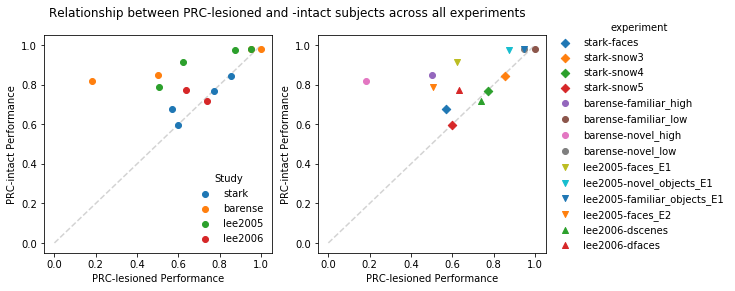

In [84]:
_m = {'stark': 'D', 'barense':'o', 'lee2005':'v', 'lee2006':'^'}

plt.figure(figsize=[9, 4])
plt.subplot(121)
for i_study in meta_df['study'].unique() : 
    _study = meta_df[meta_df['study']==i_study]
    plt.scatter( _study['prc_lesion'], _study['prc_intact'], label=i_study, )#marker=_m[_study['study'].values[0]]) 
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='--', zorder=-2)
plt.legend(title='Study', framealpha=0) 
plt.xlabel('PRC-lesioned Performance')
plt.ylabel('PRC-intact Performance')
plt.subplot(122)

for i_experiment in meta_df['experiment'].unique() : 
    _experiment = meta_df[meta_df['experiment']==i_experiment]
    i_label = '%s-%s'%(_experiment['study'].values[0], _experiment['experiment'].values[0])
    plt.scatter( _experiment['prc_lesion'], _experiment['prc_intact'], label=i_label, 
                marker=_m[_experiment['study'].values[0]]) 
plt.plot([0, 1], [0, 1], color='lightgrey', linestyle='--', zorder=-2)
plt.xlabel('PRC-lesioned Performance')
plt.ylabel('PRC-intact Performance')
plt.legend(title='experiment', bbox_to_anchor=[1,1.1],  framealpha=0) 
plt.suptitle('Relationship between PRC-lesioned and -intact subjects across all experiments'); 

### A significant difference between PRC-lesioned and PRC-intact subjects

In [85]:
prc_lesioncontrol_test = smf.ols(formula='prc_delta~1', data=meta_df).fit()

In [86]:
show_model_parameters(prc_lesioncontrol_test)[0]

0.018747595209795923


$R^{2}_{model} = 0.00$, $\beta = 0.14$, $F(0, 13)$ = $2.68, p < .05 $

### Not a significant difference between HPC-lesioned and HPC-intact subjects

In [87]:
hpc_lesionintact_test = smf.ols(formula='hpc_delta~1', data=meta_df).fit()

In [88]:
show_model_parameters(hpc_lesionintact_test)[0]

0.479340770144135


$R^{2}_{model} = -0.00$, $\beta = 0.01$, $F(0, 13)$ = $0.73, p > .05$

### A significant difference between lesioned and intact subjects by group (PRC vs. HPC)

In [260]:
prc_hpc_lesionintact_difference = {
    'delta': np.concatenate([meta_df['hpc_delta'], meta_df['prc_delta']]), 
    'group': np.concatenate([np.repeat('hpc', len(meta_df)), np.repeat('prc', len(meta_df))])}

prc_hpc_lesionintact_test = smf.ols(formula='delta~group', data=prc_hpc_lesionintact_difference).fit()
show_model_parameters(prc_hpc_lesionintact_test)[0]

0.02751145885174355


$R^{2}_{model} = 0.17$, $\beta = 0.13$, $F(1, 26)$ = $2.34, p < .05 $

## An "IT-like" model layer predicts the behavior of PRC-lesioned subjects

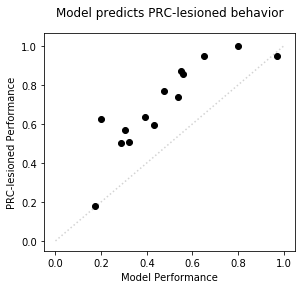

In [261]:
# determined in other analysis below
n_ = len(meta_df)

prc_it_prediction = smf.ols("prc_lesion ~ %s"%it_layer, meta_df).fit()
    
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['prc_lesion'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model predicts PRC-lesioned behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('PRC-lesioned Performance'); 

In [262]:
show_model_parameters(prc_it_prediction)[0]

7.040060508402693e-05


$R^{2}_{model} = 0.74$, $\beta = 0.86$, $F(1, 12)$ = $5.92, p < 7 $ x $ 10 ^{-5} $

## An "IT-like" model layer does not predict the behavior of HPC-lesioned subjects

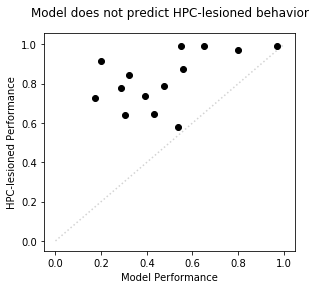

In [263]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['hpc_lesion'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model does not predict HPC-lesioned behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('HPC-lesioned Performance'); 

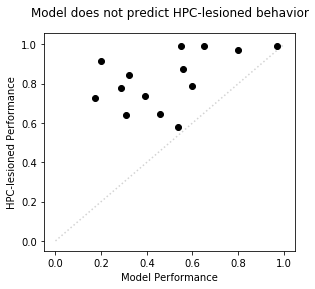

In [380]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['hpc_lesion'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model does not predict HPC-lesioned behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('HPC-lesioned Performance'); 

In [44]:
hpc_it_prediction = smf.ols("hpc_lesion ~ %s"%it_layer, meta_df).fit()
show_model_parameters(hpc_it_prediction)[0]

0.056580968368061285


$R^{2}_{model} = 0.27$, $\beta = 0.33$, $F(1, 12)$ = $2.11, p > .05$

In [381]:
hpc_it_prediction = smf.ols("hpc_lesion ~ %s"%it_layer, meta_df).fit()
show_model_parameters(hpc_it_prediction)[0]

0.07380912253671698


$R^{2}_{model} = 0.24$, $\beta = 0.31$, $F(1, 12)$ = $1.96, p > .05$

In [45]:
hpc_it_prediction = smf.ols("hpc_intact ~ %s"%it_layer, meta_df).fit()
show_model_parameters(hpc_it_prediction)[1]

0.06397439124370824


'$R^{2}_{model} = 0.26$, $\\beta = 0.28$, $F(1, 12)$ = $2.04, p > .05$'

In [386]:
hpc_it_prediction = smf.ols("hpc_intact ~ %s"%it_layer, meta_df).fit()
show_model_parameters(hpc_it_prediction)[1]

0.09594552669064389


'$R^{2}_{model} = 0.21$, $\\beta = 0.25$, $F(1, 12)$ = $1.81, p > .05$'

## An "IT-like" model layer does not predict the behavior of PRC-intact subjects

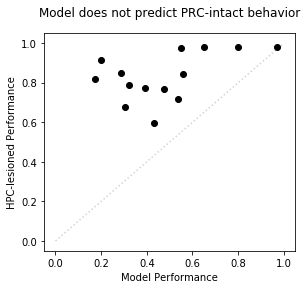

In [46]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['prc_intact'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model does not predict PRC-intact behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('HPC-lesioned Performance');

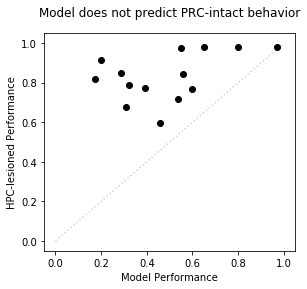

In [382]:
plt.figure(figsize=[4.5, 4])
plt.scatter(y=meta_df['prc_intact'],x=meta_df[it_layer], color='black')
plt.plot([0, 1], [0, 1], color='lightgrey', zorder=-1, linestyle=':')
plt.title('Model does not predict PRC-intact behavior', y=1.05); 
plt.xlabel('Model Performance')
plt.ylabel('HPC-lesioned Performance');

In [47]:
prcintact_it_prediction = smf.ols("prc_intact ~ %s"%it_layer, meta_df[['prc_intact', it_layer]]).fit()
show_model_parameters(prcintact_it_prediction)[0]

0.07250883992173945


$R^{2}_{model} = 0.24$, $\beta = 0.27$, $F(1, 12)$ = $1.97, p > .05$

In [383]:
prcintact_it_prediction = smf.ols("prc_intact ~ %s"%it_layer, meta_df[['prc_intact', it_layer]]).fit()
show_model_parameters(prcintact_it_prediction)[0]

0.10808405463895644


$R^{2}_{model} = 0.20$, $\beta = 0.24$, $F(1, 12)$ = $1.74, p > .05$

In [48]:
prcintact_it_prediction = smf.ols("hpc_intact ~ %s"%it_layer, meta_df[['prc_intact', it_layer]]).fit()
show_model_parameters(prcintact_it_prediction)[1]

0.06397439124370824


'$R^{2}_{model} = 0.26$, $\\beta = 0.28$, $F(1, 12)$ = $2.04, p > .05$'

In [384]:
prcintact_it_prediction = smf.ols("hpc_intact ~ %s"%it_layer, meta_df[['prc_intact', it_layer]]).fit()
show_model_parameters(prcintact_it_prediction)[1]

0.09594552669064389


'$R^{2}_{model} = 0.21$, $\\beta = 0.25$, $F(1, 12)$ = $1.81, p > .05$'

### PRC-intact control subjects ourperform the model

In [49]:
_tmpdf = pandas.DataFrame({'delta': meta_df['prc_intact']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

1.2211873337378937e-05


$R^{2}_{model} = 0.00$, $\beta = 0.36$, $F(0, 13)$ = $6.82, p < 2 $ x $ 10 ^{-5} $

In [385]:
_tmpdf = pandas.DataFrame({'delta': meta_df['prc_intact']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

2.5266657486980192e-05


$R^{2}_{model} = -0.00$, $\beta = 0.35$, $F(0, 13)$ = $6.35, p < 3 $ x $ 10 ^{-5} $

### Selective HPC-lesions subjects ourperform the model

In [50]:
_tmpdf = pandas.DataFrame({'delta': meta_df['hpc_lesion']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

1.6075432954546815e-05


$R^{2}_{model} = -0.00$, $\beta = 0.35$, $F(0, 13)$ = $6.64, p < 2 $ x $ 10 ^{-5} $

In [51]:
_tmpdf = pandas.DataFrame({'delta': meta_df['hpc_lesion']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[0]

1.6075432954546815e-05


$R^{2}_{model} = -0.00$, $\beta = 0.35$, $F(0, 13)$ = $6.64, p < 2 $ x $ 10 ^{-5} $

In [52]:
_tmpdf = pandas.DataFrame({'delta': meta_df['hpc_intact']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[1]

1.1617552957581005e-05


'$R^{2}_{model} = 0.00$, $\\beta = 0.36$, $F(0, 13)$ = $6.85, p < 2 $ x $ 10 ^{-5} $'

In [222]:
_tmpdf = pandas.DataFrame({'delta': meta_df['hpc_intact']-meta_df[it_layer]})
prcintact_model_delta = smf.ols("delta ~ 1", _tmpdf).fit()
show_model_parameters(prcintact_model_delta)[1]

2.416278897546098e-05


'$R^{2}_{model} = -0.00$, $\\beta = 0.35$, $F(0, 13)$ = $6.38, p < 2 $ x $ 10 ^{-5} $'

### SIgnificant interaction between PRC-intact and -lesioned subjects

In [53]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((meta_df[it_layer], meta_df[it_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_intact'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
prcinteraction = smf.ols("human ~ model * group", tmpdf).fit()
show_model_parameters(prcinteraction)[0]

0.006597169685024327


$R^{2}_{model} = 0.68$, $\beta = 0.59$, $F(3, 24)$ = $2.97, p < 7 $ x $ 10 ^{-3} $

In [387]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((meta_df[it_layer], meta_df[it_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_intact'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
prcinteraction = smf.ols("human ~ model * group", tmpdf).fit()
show_model_parameters(prcinteraction)[0]

0.005075410326743785


$R^{2}_{model} = 0.67$, $\beta = 0.62$, $F(3, 24)$ = $3.08, p < 5 $ x $ 10 ^{-3} $

In [54]:
### No relationship with HPC group

In [55]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((meta_df[it_layer], meta_df[it_layer])), 
     'human': np.concatenate((meta_df['hpc_lesion'], meta_df['hpc_intact'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
hpcinteraction = smf.ols("human ~ model * group", tmpdf).fit()
show_model_parameters(hpcinteraction)[0]

0.8193677567689106


$R^{2}_{model} = 0.27$, $\beta = 0.05$, $F(3, 24)$ = $0.23, p > .05$

In [374]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((meta_df[it_layer], meta_df[it_layer])), 
     'human': np.concatenate((meta_df['hpc_lesion'], meta_df['hpc_intact'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
hpcinteraction = smf.ols("human ~ model * group", tmpdf).fit()
show_model_parameters(hpcinteraction)[0]

0.7972758469355289


$R^{2}_{model} = 0.23$, $\beta = 0.05$, $F(3, 24)$ = $0.26, p > .05$

### PRC-dependence scales with model performance

In [56]:
linear_dependence = smf.ols('prc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

0.005315930687553991


$R^{2}_{model} = 0.49$, $\beta = -0.59$, $F(1, 12)$ = $-3.40, p < 6 $ x $ 10 ^{-3} $

In [388]:
linear_dependence = smf.ols('prc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

0.0028956358265286213


$R^{2}_{model} = 0.54$, $\beta = -0.62$, $F(1, 12)$ = $-3.73, p < 3 $ x $ 10 ^{-3} $

### No relationship between HPC-intact -- lesioned behaviors  and model performance 

In [57]:
linear_dependence = smf.ols('hpc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

0.5482796484000976


$R^{2}_{model} = 0.03$, $\beta = -0.05$, $F(1, 12)$ = $-0.62, p > .05$

In [375]:
linear_dependence = smf.ols('hpc_delta ~ %s '%(it_layer), meta_df).fit()
show_model_parameters(linear_dependence)[0]

0.48825507084892883


$R^{2}_{model} = 0.04$, $\beta = -0.05$, $F(1, 12)$ = $-0.72, p > .05$

# Visualize Main Finding

In [59]:
# helper function
def plot_nice_line(model_, params={}, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
    plt.plot(xs, xs * m + b, **params, solid_capstyle = ['butt', 'round', 'projecting'][1])
# helper function
def plot_diagonal(label=''): 
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', zorder=-1, label=label)

def meta_analytic_results(i_layer): 
    
    # data 
    mod_ = meta_df[i_layer].values
    prc_ = meta_df['prc_lesion'].values
    hpc_ = meta_df['hpc_lesion'].values
    jp_ = meta_df['prc_intact'].values
    con_ = meta_df['prc_intact'].values
    
    # define global plot
    plt.figure(figsize=[18, 4])
    y_lim = (-.05, 1.05)
    prc_c = '#9a2487'
    con_c = '#a3a3a3' 
    hpc_c = '#037397'
    x_model_name = 'Model Performance'
    xy_lsize = 12
    p_width = 1
    p_size = 15
    l_width = 5
    t_size = 8
    xlabelpad = 10 
    ylabelpad = 4
    _alpha = .9
    
    ################
    ax = plt.subplot(141);
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':1, 'edgecolor':prc_c, 'facecolor':'white'}
    con_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_, (-1, 1)))
    plt.scatter(x = mod_, y = prc_, **point_params) 
    
    line_params = {'linewidth':l_width,'color':con_c,'label':'MTL-intact controls', 'alpha':_alpha, 'zorder':0}
    #plot_nice_line(con_model_, line_params)
    
    # prc-lesion data
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':1, 'edgecolor':prc_c, 'facecolor':'white'}
    prc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(prc_, (-1, 1)))
    _params = {'linewidth':l_width, 'zorder':-1, 'color':prc_c, 'alpha':_alpha}
    plot_nice_line(prc_model_, _params)
    plt.scatter(x = mod_, y = prc_, **point_params) 
    # aesthetics
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    plt.ylabel('PRC-lesion Performance', fontsize=xy_lsize, labelpad=ylabelpad)
    plt.scatter([], [], **point_params, label='Single Experiment')
    #plt.title('PRC-Lesioned Behavior\n'  , fontsize=t_size, y=1.05)
    plt.ylim(y_lim) 
    plot_diagonal(label='Model Prediction') 
    plt.legend(fontsize=10, title_fontsize=8, framealpha=0, loc=4 )
    plt.xticks(size=t_size); plt.yticks(size=t_size)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][0], transform=ax.transAxes,fontsize=12, va='top', ha='right')
    
    ################
    ax = plt.subplot(142)
    # mtl-intact data
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':3, 'edgecolor':con_c, 'facecolor':'white'}
    plt.scatter(x = mod_, y = con_, **point_params)
    con_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_, (-1, 1)))
    line_params = {'linewidth':l_width,'color':con_c,'label':'MTL-intact controls', 'alpha':_alpha, 'zorder':0}
    plot_nice_line(con_model_, line_params)
    # hpc-lesion data
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':2, 'edgecolor':hpc_c, 'facecolor':'white'}
    plt.scatter(x = mod_, y = hpc_, **point_params); 
    hpc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(hpc_, (-1, 1)))
    line_params = {'linewidth':l_width, 'zorder':1, 'color':hpc_c, 'label':'Selective HPC lesion', 'alpha':_alpha}
    plot_nice_line(hpc_model_, line_params)
    # aesthetics
    plot_diagonal()
    plt.ylim(y_lim)
    plt.ylabel('PRC-intact Performance', fontsize=xy_lsize, labelpad=ylabelpad)
    #plt.title('PRC-Intact Behavior\n' , fontsize=t_size, y=1.05)
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    plt.legend(title='', fontsize=10, title_fontsize=10, framealpha=0, loc=4)
    plt.xticks(size=t_size); plt.yticks(size=t_size)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][1], transform=ax.transAxes,fontsize=12, va='top', ha='right')
    
    ################
    ax = plt.subplot(143) 
    cline_params = {'linewidth':l_width, 'zorder':1, 'color': con_c, 'label': 'PRC-intact', 'alpha':_alpha}
    hline_params = {'linewidth':l_width,'color': prc_c,'label': 'PRC-lesion', 'alpha':_alpha}
    # data
    plot_nice_line(con_model_, cline_params)
    plot_nice_line(prc_model_, hline_params)
    # aesthetics
    plot_diagonal()
    #plt.title('Evidence for PRC-Dependence\n', fontsize=t_size, y=1.05)
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    plt.ylim(y_lim)
    plt.legend(title='Patient Group', fontsize=10, title_fontsize=10, framealpha=0, loc=4)
    plt.ylabel('Human Performance', fontsize=xy_lsize, labelpad=ylabelpad)
    plt.xticks(size=t_size); plt.yticks(size=t_size)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][2], transform=ax.transAxes,fontsize=12, va='top', ha='right')
    
    
    ####################
    ax = plt.subplot(144)
    # aesthetics aesthetics aesthetics 
    l_width = .5
    s_size = 35
    d_params = {'s':s_size,'linewidth':l_width, 'zorder':-1, 'edgecolor':'black'}
    _c = {'for':'black', 'against':'white'}
    _m = {'control':'p', 'diagnostic':'^'}
    _params = {'s':s_size,'linewidth':l_width, 'edgecolor':'black'}
    plt.xlim(min(mod_)-.1, max(mod_)+.1)
    plt.ylim(min(meta_df['prc_delta'])-.1, max(meta_df['prc_delta'])+.1)
    #plt.title('PRC-dependence scales \nwith Model failure', fontsize=t_size, y=1.05)
    plt.ylabel('$\Delta$'' Performance ''$_{( prc.intact - prc.lesion )}$', fontsize=xy_lsize, labelpad=ylabelpad-6)
    plt.xticks(size=t_size); plt.yticks(size=t_size)
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    _c = {'for':'black', 'against':'white', 'control':'#cccccc'}
    _m = {'control':'^', 'diagnostic':'^'}
    _params = {'s':s_size,'linewidth':l_width, 'zorder':-1, 'edgecolor':'black'}
    plt.scatter([], [], **_params, facecolor=_c['for'],  marker=_m['diagnostic'], label='support')
    plt.scatter([], [], **_params, facecolor=_c['against'],  marker=_m['diagnostic'], label='refute')
    plt.scatter([], [], **_params, facecolor=_c['control'],  marker=_m['control'], label='control')
    plt.legend(title='Author\'s claim of\nPRC involvement', framealpha=0, fontsize=8, title_fontsize=8)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][3], transform=ax.transAxes, fontsize=12, va='top', ha='right')
    # data
    for i in range(len(meta_df)): 
        exp = meta_df.iloc[i]
        _fcolor = [_c[exp['claim']], _c['control']][exp['type']=='control']
        plt.scatter(y=exp['prc_delta'], x=exp[i_layer], 
                    facecolor=_fcolor, marker=_m[exp['type']], **_params)
    
    filename = 'prc-lesion_mtl-intact_lesion_with_divergence_%s.pdf'%i_layer
    save_name = os.path.join(_location, filename)
    plt.savefig(save_name, format='pdf', bbox_inches = "tight")

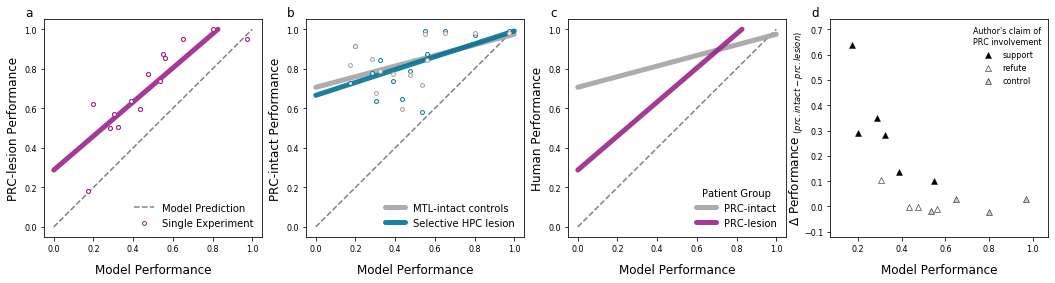

In [60]:
meta_analytic_results( it_layer )

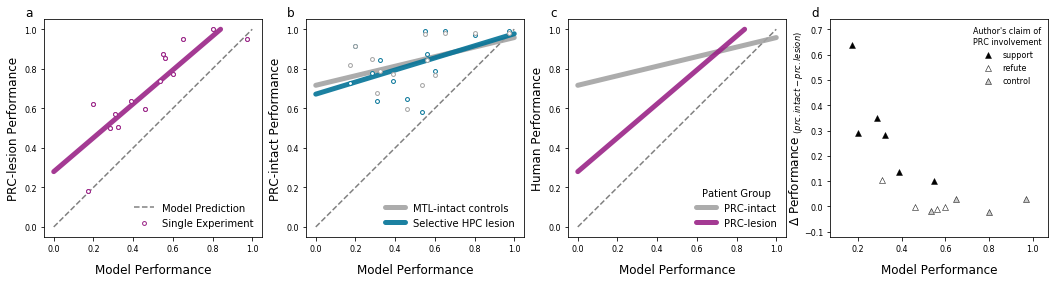

In [227]:
meta_analytic_results( it_layer )

In [61]:
# helper function
def plot_nice_line(model_, params={}, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
    return plt.plot(xs, xs * m + b, **params, solid_capstyle = ['butt', 'round', 'projecting'][1])
# helper function
def plot_diagonal(label=''): 
    return plt.plot([0, 1], [0, 1], color='grey', linestyle='--', zorder=-1, label=label)

intact = {} 
lesion = {} 
contro = {} 

intact['barense'] = [.98, .85, .88]
lesion['barense'] = [1., .26, .38]
contro['barense'] = [1., .87, .89]
intact['inhoff'] = [.71, .65, .53]
lesion['inhoff'] = [.47, .45, .27]
contro['inhoff'] = [.65, .67, .55]
intact['knutson'] = [1.  , 1.  , 0.94, 1.  , 0.75, 0.71, 0.75, 0.25]
lesion['knutson'] = [0.99, 0.96, 0.95, 0.84, 0.83, 0.79, 0.79, 0.54]
contro['knutson'] = [0.98, 0.9 , 0.92, 0.72, 0.75, 0.29,  nan,  nan]
intact['buffalo'] = [.67]
lesion['buffalo']  = [.7]
contro['buffalo'] = [.68]

i = [] 
l = [] 
c = [] 
for study in intact: 
    i.extend(intact[study])
    l.extend(lesion[study])
    c.extend(contro[study])
i = np.array(i)
l = np.array(l)
c = np.array(c)

# prc_c = '#9a2487'
# con_c = '#a3a3a3' 
# hpc_c = '#037397'
# plt.figure(figsize=[9, 4])
# plt.subplot(121)
# plt.scatter(np.repeat(1., len(i)), i, label='intact', facecolor=con_c, edgecolor='')
# plt.scatter(np.repeat(1.04, len(l)), l, label='lesion', facecolor=prc_c, edgecolor='')
# plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
# plt.legend(title='PRC GROUP', framealpha=0) ; 
# plt.xticks([0., .2, .4, .6, .8, 1, 1.04], [0., .2, .4, .6, .8, 1, 1]); 
# plt.subplot(122)
# plt.scatter(np.repeat(1., len(i)), i, label='intact', facecolor=con_c, edgecolor='')
# plt.scatter(np.repeat(1.04, len(c)), c, label='lesion', facecolor=hpc_c, edgecolor='')
# plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
# plt.legend(title='HPC GROUP', framealpha=0) ; 
# plt.xticks([0., .2, .4, .6, .8, 1, 1.04], [0., .2, .4, .6, .8, 1, 1]); 

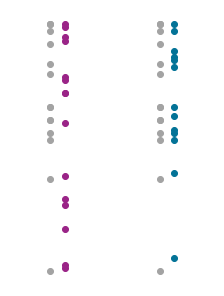

In [62]:
prc_c = '#9a2487'
con_c = '#a3a3a3' 
hpc_c = '#037397'

fig = plt.figure(constrained_layout=True, figsize=[3, 4])
gs = fig.add_gridspec(3, 2, wspace=0, hspace=1) 

ax = fig.add_subplot(gs[0:3, 0:1]); 
plt.scatter(np.repeat(0, len(i)), i, facecolor=con_c,)
plt.scatter(np.repeat(.1, len(l)), l, facecolor=prc_c,)
plt.xlim(-.3, .4, )
plt.axis('off')

ax = fig.add_subplot(gs[0:3, 1:2]); 
plt.scatter(np.repeat(0, len(i)), i, facecolor=con_c,)
plt.scatter(np.repeat(.1, len(c)), c, facecolor=hpc_c,)
plt.xlim(-.3, .4, )
plt.axis('off');

In [230]:
# helper function
def plot_nice_line(model_, params={}, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
    return plt.plot(xs, xs * m + b, **params, solid_capstyle = ['butt', 'round', 'projecting'][1])
# helper function
def plot_diagonal(label=''): 
    return plt.plot([0, 1], [0, 1], color='grey', linestyle='--', zorder=-1, label=label)

def meta_analytic_results(i_layer, i, l, c): 
    
    # data 
    mod_ = meta_df[i_layer].values
    prc_ = meta_df['prc_lesion'].values
    hpc_ = meta_df['hpc_lesion'].values
    con_prc = meta_df['prc_intact'].values
    con_hpc = meta_df['hpc_intact'].values
    
    # define global plot
    #plt.figure(figsize=[9, 4])
    
    fig = plt.figure(constrained_layout=True, figsize=[7.5, 4])
    gs = fig.add_gridspec(2, 4) 

    y_lim = (-.05, 1.05)
    prc_c = '#9a2487'
    con_c = '#a3a3a3' 
    hpc_c = '#037397'
    x_model_name = 'Model Performance'
    xy_lsize = 12
    p_width = 1
    p_size = 30
    l_width = 5
    t_size = 8
    xlabelpad = 10 
    ylabelpad = 4
    _alpha = .9
    nd_lwidth=.7
    ################
    ax = fig.add_subplot(gs[0:2, 0:2]); 
    
    con_c = '#dadada'#'#d1d1d1'
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':-2, 'facecolor':con_c, 'edgecolor':'white',}
    prccon_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_prc, (-1, 1)))
    points = plt.scatter(x = mod_, y = con_prc, **point_params) 
    prediction_line = plot_diagonal() 
    line_params = {'linewidth':l_width,'color':con_c,'label':'PRC-intact', 'alpha':_alpha, 'zorder':-3}
    con_line = plot_nice_line(prccon_model_, line_params)
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-2)
    # prc-lesion data
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':2, 'facecolor':prc_c, 'edgecolor':'white'}
    prc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(prc_, (-1, 1)))
    _params = {'linewidth':l_width, 'zorder':-1, 'color':prc_c, 'alpha':_alpha, 'label':'PRC-lesion'}
    prc_line = plot_nice_line(prc_model_, _params)
    plt.scatter(x = mod_, y = prc_, **point_params) 
    # aesthetics
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    plt.ylabel('Human Performance', fontsize=xy_lsize, labelpad=ylabelpad)
    #plt.title('PRC-Lesioned Behavior\n'  , fontsize=t_size, y=1.05)
    plt.ylim(y_lim) 

    plt.xticks(size=t_size); plt.yticks(size=t_size)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][0], transform=ax.transAxes,fontsize=12, va='top', ha='right')
    
    plt.scatter(np.repeat(1., len(i)), i, facecolor='white', edgecolor=con_c, s=p_size-10,linewidth=nd_lwidth)
    plt.scatter(np.repeat(1., len(l)), l, facecolor='white', edgecolor=prc_c,s=p_size-10,linewidth=nd_lwidth)
    
    plt.legend(fontsize=10, title_fontsize=8, framealpha=0, loc=4)
    
    ################
    ax = fig.add_subplot(gs[0:2, 2:4]); 
    
    # mtl-intact data
    con_c = '#d1d1d1'
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':-5, 'facecolor':con_c, 'edgecolor':'white'}
    A = plt.scatter(x = mod_, y = con_hpc, **point_params )
    con_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_hpc, (-1, 1)))
    line_params = {'linewidth':l_width,'color':con_c,'label':'HPC-intact', 'alpha':_alpha, 'zorder':0}
    plot_nice_line(con_model_, line_params)
    # hpc-lesion data
    point_params = {'s':p_size,'linewidth':p_width, 'zorder':2, 'facecolor':hpc_c, 'edgecolor':'white'}
    plt.scatter(x = mod_, y = hpc_, **point_params); 
    hpc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(hpc_, (-1, 1)))
    line_params = {'linewidth':l_width, 'zorder':1, 'color':hpc_c, 'label':'HPC-lesion', 'alpha':_alpha}
    plot_nice_line(hpc_model_, line_params)
    # aesthetics
    plot_diagonal()
    plt.ylim(y_lim)
    #plt.ylabel('PRC-intact Performance', fontsize=xy_lsize, labelpad=ylabelpad)
    #plt.title('PRC-Intact Behavior\n' , fontsize=t_size, y=1.05)
    plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
    L1 = plt.legend(title='', fontsize=10, title_fontsize=10, framealpha=0, loc=4)
    plt.xticks(size=t_size); plt.yticks(size=t_size)
    ax.text(-0.05, 1.06, ['a','b','c', 'd'][1], transform=ax.transAxes,fontsize=12, va='top', ha='right')
    
    plt.scatter(np.repeat(1., len(i)), i, facecolor='white', edgecolor=con_c, s=p_size-10, linewidth=nd_lwidth)
    plt.scatter(np.repeat(1., len(c)), c, facecolor='white', edgecolor=hpc_c,s=p_size-10, linewidth=nd_lwidth)
    
    #A = plt.scatter([], [], edgecolor=con_c, facecolor='white', marker='o', linewidth=1)
    #B = plt.scatter([], [], color=con_c,)
    #plt.legend([A, B], ['PRC-relevant', 'PRC-irrelevant'], bbox_to_anchor=[1.55, .215], framealpha=0)
    #plt.gca().add_artist(L1)
    
#     ax = fig.add_subplot(gs[2:4, 1:3]); 
#     l_width = .5
#     s_size = 35
#     d_params = {'s':s_size,'linewidth':l_width, 'zorder':-1, 'edgecolor':'black'}
#     _c = {'for':'black', 'against':'white'}
#     _m = {'control':'p', 'diagnostic':'^'}
#     _params = {'s':s_size,'linewidth':l_width, 'edgecolor':'black'}
#     plt.xlim(min(mod_)-.1, max(mod_)+.1)
#     plt.ylim(min(meta_df['prc_delta'])-.1, max(meta_df['prc_delta'])+.1)
#     #plt.title('PRC-dependence scales \nwith Model failure', fontsize=t_size, y=1.05)
#     plt.ylabel('$\Delta$'' Performance ''$_{( prc.intact - prc.lesion )}$', 
#                fontsize=xy_lsize-1, labelpad=ylabelpad-6)
#     plt.xticks(size=t_size); plt.yticks(size=t_size)
#     plt.xlabel(x_model_name, fontsize=xy_lsize, labelpad=xlabelpad)
#     _c = {'for':'black', 'against':'white', 'control':'#cccccc'}
#     _m = {'control':'^', 'diagnostic':'^'}
#     _params = {'s':s_size,'linewidth':l_width, 'zorder':-1, 'edgecolor':'black'}
#     plt.scatter([], [], **_params, facecolor=_c['for'],  marker=_m['diagnostic'], label='support')
#     plt.scatter([], [], **_params, facecolor=_c['against'],  marker=_m['diagnostic'], label='refute')
#     plt.scatter([], [], **_params, facecolor=_c['control'],  marker=_m['control'], label='control')
#     plt.legend(title='Author\'s claim of\nPRC involvement', framealpha=0, fontsize=8, title_fontsize=8)
#     ax.text(-0.05, 1.06, ['a','b','c', 'd'][2], transform=ax.transAxes, fontsize=12, va='top', ha='right')
#     # data
#     for i in range(len(meta_df)): 
#         exp = meta_df.iloc[i]
#         _fcolor = [_c[exp['claim']], _c['control']][exp['type']=='control']
#         plt.scatter(y=exp['prc_delta'], x=exp[i_layer], 
#                     facecolor=_fcolor, marker=_m[exp['type']], **_params)
        
    filename = 'prc_mtl_intact_compact_%s.pdf'%i_layer
    save_name = os.path.join(_location, filename)
    plt.savefig(save_name, format='pdf', bbox_inches = "tight")

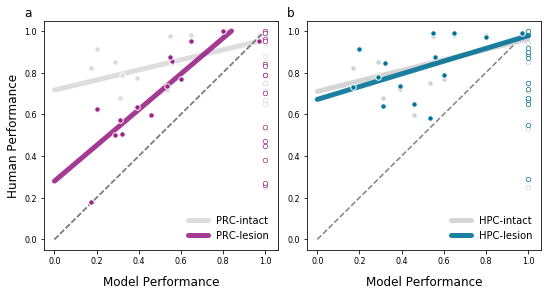

In [231]:
meta_analytic_results( it_layer, i, l, c) 

### A quadratic model predict prc-dependence

In [232]:
quadratic = smf.ols('prc_delta ~ %s + np.power(%s, 2)'%(it_layer, it_layer), meta_df).fit()
show_model_parameters(quadratic)[0]

0.002551424779397604


$R^{2}_{model} = 0.80$, $\beta = 1.70$, $F(2, 11)$ = $3.88, p < 2 $ x $ 10 ^{-3} $

### A "V4-like" model layer also predict the behavior of PRC-intact subjects

In [233]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((meta_df[v4_layer], meta_df[v4_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_intact'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
prcinteraction_v4 = smf.ols("human ~ model * group", tmpdf).fit()
show_model_parameters(prcinteraction_v4)[0]

0.012602686843695749


$R^{2}_{model} = 0.63$, $\beta = 0.62$, $F(3, 24)$ = $2.70, p < .05 $

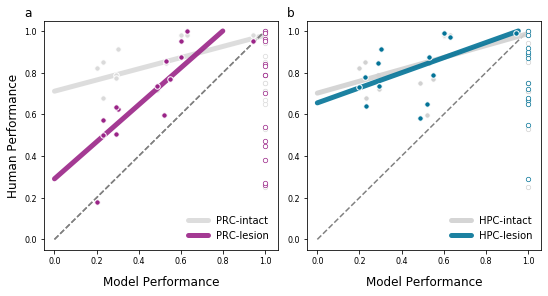

In [234]:
meta_analytic_results(v4_layer, i, l, c) 

# Focal Anatomical Dependencies

In [235]:
def layer_plot(ax, A=1, B=1, C=1): 
    def annotate(region): 
        _xy = pls_fits[region]['mu']
        plt.annotate("'%s-like'"%region.upper(), 
                     xy=(argmax(_xy)-.8, max(_xy)+.08), size=7, rotation=0, color='grey')
        plt.scatter(x=argmax(_xy), y=max(_xy), marker='|', color='black', s=200, linewidth=.5)
        #ax.spines['right'].set_visible(False)
        #ax.spines['top'].set_visible(False)
        
        
    v4_color='black'
    it_color='black'
    n_layers = len(pls_delta)
    i_alpha=.1

    if A: 
        # V4 
        plt.plot(pls_fits['v4']['mu'], color=v4_color, linestyle='--', linewidth=1, alpha=1, label='V4') 
        y_min = pls_fits['v4']['mu']-(pls_fits['v4']['std']/np.sqrt(len(pls_fits['v4']['std'])))
        y_max = pls_fits['v4']['mu']+(pls_fits['v4']['std']/np.sqrt(len(pls_fits['v4']['std'])))
        plt.fill_between(x=range(n_layers),y1=y_min, y2=y_max, 
                         color=v4_color, alpha=i_alpha, edgecolor='', linewidth=0, )
        plt.yticks(size=6)
        plt.ylabel('Cross-validated fit to Neural Data', labelpad=0, fontsize=11)
        annotate('v4')
    if B: 
        # IT 
        plt.plot(pls_fits['it']['mu'], color=it_color, linestyle='-', linewidth=1, alpha=1, label='IT') 
        y_min = pls_fits['it']['mu']-(pls_fits['it']['std']/np.sqrt(len(pls_fits['v4']['std'])))
        y_max = pls_fits['it']['mu']+(pls_fits['it']['std']/np.sqrt(len(pls_fits['v4']['std'])))
        plt.fill_between(x=range(n_layers),y1=y_min, y2=y_max, 
                         color=it_color, alpha=i_alpha, edgecolor='', linewidth=0, )
        
        annotate('it')
    if C: 
        # DELTA 
        y_ =  pls_fits['delta']['mu']
        params = {'solid_capstyle':'round', 'linewidth':5, 'zorder':1,}
        plt.plot(range(len(y_)), y_, color='white', 
                 path_effects=[matplotlib.patheffects.Stroke(linewidth=3, foreground='black'), pe.Normal()], 
                label='$\Delta_{IT - V4}$')
    plt.ylim(min(pls_fits['delta']['mu'])-.1, max(pls_fits['v4']['mu'])+.15)
    
    # AESTHETICS
    plt.xlabel("Model Layer", labelpad=5, fontsize=10)
    plt.xticks(range(len(list(pls_delta))), list(pls_delta), rotation=90, fontsize=7);
    plt.legend(framealpha=0, fontsize=9, title_fontsize=9,loc=4)

In [236]:
def show_layer_fit(i_layer, group, show_x=0, show_y=0, show_tag=0): 
    
    xleg = {'pool1':'(Pre \'V4-like\' Layer)', 
            'pool3':'(\'V4-like\' Layer)', 
            'conv5_1': '(\'IT-like\' Layer)' ,
            'fc7':'(Latter \'IT-like\' Layer)'}
    
    y_tag = 'Human Performance'#%group.upper()
    l_tag = '%s-lesioned'%group.upper()
    x_layer = meta_df[i_layer].values
    y_intact = meta_df['%s_intact'%group].values
    y_lesion = meta_df['%s_lesion'%group].values
    i_color = layer_data['%s_colors'%group].values[np.nonzero( layer_data.layer.values == i_layer )[0][0]]

    l_line = LinearRegression().fit(np.reshape(x_layer, (-1,1)), np.reshape(y_lesion, (-1, 1)))
    i_line = LinearRegression().fit(np.reshape(x_layer, (-1,1)), np.reshape(y_intact, (-1, 1)))
    params = {'facecolor':i_color, 'edgecolor':'white', 's':5, 'linewidth':.2, 'zorder':10}

    plt.scatter(x = x_layer, y = y_lesion, **params)
    plt.plot((0, 1), (0, 1), color='grey', linestyle='--', linewidth=.6, alpha=.5) 

    line_params = {'solid_capstyle':'round', 'linewidth':3}
    xs = np.array([0, min(1 , ( ( 1 - l_line.intercept_[0] ) / l_line.coef_[0] ))] ) 
    plt.plot(xs, xs * l_line.coef_[0] + l_line.intercept_[0], color=i_color, **line_params, label='patient')
    intact_params = {'color': 'lightgrey', 'alpha':1, 'zorder':-5}

    xs = np.array([0, min(1 , ( ( 1 - i_line.intercept_[0] ) / i_line.coef_[0] ))] ) 
    plt.plot(xs, xs * i_line.coef_[0] + i_line.intercept_[0], **line_params, **intact_params)
    plt.plot([], [] , **line_params, **intact_params,label='control')
    plt.scatter(x = x_layer, y = y_intact, facecolor='lightgrey',s=5, linewidth=.5, edgecolor='', zorder=-2)

    if show_y: 
        plt.yticks([0.0, .5, 1.0], [0.0, .5, 1.0], size=7)
        plt.ylabel('%s'%y_tag, labelpad=5, fontsize=9, x=10)
        plt.legend( loc=4, framealpha=0, fontsize=7, title_fontsize=7, title=l_tag)
    else: 
        plt.yticks([])
    
    plt.ylim([-.1, 1.1]); plt.xlim([-.1, 1.1])
    if group=='hpc': 
        plt.xticks(fontsize=7)
        plt.xlabel('Model$_{%s}$ Performance\n %s' %(i_layer, xleg[i_layer]), labelpad=7, fontsize=9)
    else: 
        plt.xticks([])

In [237]:
def gradient_show(): 
    
    y_start = .063
    prc_offset = .007
    y_center=.0015
    x_start = -.30
    x_shift = .09
    l_fontsize=6

    colors = [i.rgb for i in colour.Color('#4B0082').range_to(colour.Color('#FF1493'), 20)]
    [plt.plot(np.array([i, i+1])/300+x_start,(y_start+prc_offset, y_start+prc_offset), color=colors[i], linewidth=4) for i in range(len(colors))]; 
    plt.annotate('PRC', xy=(x_start+x_shift, y_start+prc_offset-y_center), fontsize=l_fontsize)
    cs = [i.rgb for i in colour.Color('darkblue').range_to(colour.Color('#00FFFF'), 20)]
    [plt.plot(np.array([i, i+1])/300+x_start,(y_start, y_start), color=cs[i], linewidth=4) for i in range(len(cs))]; 
    plt.annotate('HPC', xy=(x_start+x_shift,y_start-y_center), fontsize=l_fontsize)
    plt.annotate('Lesion Group', xy=(x_start-.035, y_start+prc_offset*2), fontsize=l_fontsize)
    

def nice_legends(): 
    plt.scatter([], [], s=20,  linewidth=.7, facecolor='white', edgecolor='black', label='p$_{corrected}$ < 0.05')
    #plt.scatter([], [], **plot_params, **color_params, facecolor='white', edgecolor='lightgrey', label='non-significant')
    plt.legend(title='Interaction', framealpha=0, title_fontsize=l_fontsize, fontsize=l_fontsize-1, 
               loc=3, bbox_to_anchor=[.45, .335]) # 'Interaction ('r'$\alpha$''=.05)'

    for region in ['it', 'v4']: 

        i_layer = {'it':it_layer, 'v4':v4_layer}[region]

        __y = layer_data[layer_data.layer==i_layer].prc_delta_rmse.values[0]
        __x = pls_delta[i_layer]['mu']
        y_offset = __y+[-.02, .02][region=='v4']
        plt.annotate("'%s-like' Layer"%region.upper(), 
                     xy=(__x-.06, y_offset), fontsize=l_fontsize, color='grey',  
                     bbox={'alpha':1, 'color':'white'})
        plt.plot([__x, __x], [__y, y_offset], linewidth=.5, alpha=.3, linestyle=":", zorder=-3, color='black')

### Visualization relationship between model, electrophysiological data, and retrospective analysis

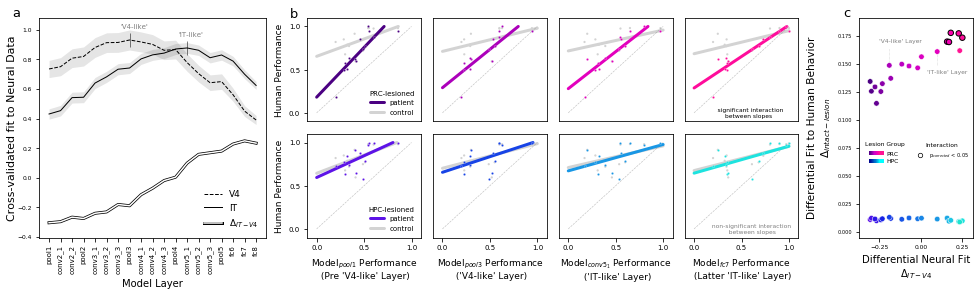

In [404]:
fig = plt.figure(constrained_layout=True, figsize=[13.5, 4])
gs = fig.add_gridspec(2, 8) 

# pls fits
ax = fig.add_subplot(gs[0:2, 0:2]); 
order = list(pls_delta)
layer_plot(ax) 
ax.text(-0.08, 1.05, 'a', transform=ax.transAxes,fontsize=13, va='top', ha='right')

# perirhinal 
f_ax = fig.add_subplot(gs[0:1, 2:3])
show_layer_fit('pool1', 'prc', show_y=1)
f_ax.text(-0.08, 1.10, 'b', transform=f_ax.transAxes,fontsize=13, va='top', ha='right')

f_ax = fig.add_subplot(gs[0:1, 3:4])
show_layer_fit('pool3', 'prc', show_tag=1)

f_ax = fig.add_subplot(gs[0:1, 4:5])
show_layer_fit('conv5_1', 'prc')

f_ax = fig.add_subplot(gs[0:1, 5:6])
show_layer_fit('fc7', 'prc')
plt.annotate('    significant interaction \n        between slopes', 
             xy=(.17, -.05), fontsize=6, color='black')

#hippocampal 
f_ax = fig.add_subplot(gs[1:2, 2:3])
show_layer_fit('pool1', 'hpc', show_x=1, show_y=1)
f_ax = fig.add_subplot(gs[1:2, 3:4])
show_layer_fit('pool3', 'hpc', show_x=1, show_tag=1)
f_ax = fig.add_subplot(gs[1:2, 4:5])
show_layer_fit('conv5_1','hpc', show_x=1, show_tag=1)
f_ax = fig.add_subplot(gs[1:2, 5:6])
show_layer_fit('fc7', 'hpc')
plt.annotate(' non-significant interaction \n          between slopes ', 
             xy=(.17, -.05), fontsize=6, color='grey')

# params for both plots
i_size = 30
l_fontsize=6
plot_params = {'marker':'o', 's':i_size}
color_params = {'linewidth':.5}
x_ = pls_fits['delta']['mu']

x_label_size = 12
######################################
f_ax = fig.add_subplot(gs[0:2, 7:8])
f_ax.text(-0.08, 1.05, 'c', transform=f_ax.transAxes,fontsize=13, va='top', ha='right')

#### PRC DATA 
_alpha = (.05/len(pls_fits['it']['mu']))
y_prc_ = layer_data['prc_intact_rmse'] - layer_data['prc_lesion_rmse']
sig_line = [['white', 'black'][i==True] for i in np.array(layer_data['prc_interaction']) < _alpha ]
lwidth = [[.5,1][i==True] for i in np.array(layer_data['prc_interaction']) < _alpha ]
plt.scatter(x_, y_prc_, **plot_params, linewidth=lwidth, facecolor=layer_data['prc_colors'], edgecolor=sig_line)

#### HPC DATA 
sig_line = [['white', 'black'][i==True] for i in np.array(layer_data['hpc_interaction']) < _alpha ]
y_hpc_ = layer_data['hpc_intact_rmse'] - layer_data['hpc_lesion_rmse']
plt.scatter(x_, y_hpc_, **plot_params, **color_params, facecolor=layer_data['hpc_colors'], edgecolor=sig_line)
 
### AESTHETICS 
plt.xticks(size=6)
plt.yticks(fontsize=5)
x_label = 'Differential Neural Fit\n$\Delta_{IT - V4}$'
plt.xlabel(x_label, fontsize=10, labelpad=5)
plt.ylabel('Differential Fit to Human Behavior\n$\Delta_{intact-lesion}$', fontsize=10.5, labelpad=5) 
plt.ylim(-.005, .191)

gradient_show()
nice_legends()
save_location = os.path.join(_location, 'VVSfit_metaanalysis.pdf')
plt.savefig(save_location, format='pdf', bbox_inches = "tight")

### layers that better fit IT cortex better predict PRC-lesioned behavior

In [417]:
layer_data[layer_data['prc_interaction'] < _alpha][['prc_interaction', 'layer']]

,prc_interaction,layer
15,0.001887,conv5_2
16,0.001870,conv5_3
17,0.001298,pool5
18,0.001521,fc6
19,0.002324,fc7


In [419]:
layer_data[layer_data['prc_interaction'] < _alpha][['hpc_interaction', 'layer']]

,hpc_interaction,layer
15,0.774854,conv5_2
16,0.846434,conv5_3
17,0.829696,pool5
18,0.848124,fc6
19,0.828175,fc7


In [420]:
delta_prc_delta_it = smf.ols("zscore(prc_delta_rmse) ~ zscore(delta_fit)", layer_data).fit()
show_model_parameters(delta_prc_delta_it)[0]

2.937576633252706e-09


$R^{2}_{model} = 0.88$, $\beta = 0.94$, $F(1, 17)$ = $11.18, p < 3 $ x $ 10 ^{-9} $

### Also true (ish) for HPC lesioned subjects, but in the other direction 

In [421]:
delta_prc_delta_it = smf.ols("zscore(hpc_delta_rmse) ~ zscore(delta_fit)", layer_data).fit()
show_model_parameters(delta_prc_delta_it)[0]

0.027111981105752907


$R^{2}_{model} = 0.26$, $\beta = -0.51$, $F(1, 17)$ = $-2.42, p < .05 $

### There is an interaction between patient groups and differenti fit to IT

In [394]:
itfit_by_lesion_data = pandas.DataFrame({
    'human': np.concatenate([layer_data['prc_delta_rmse'].values, layer_data['hpc_delta_rmse'].values]), 
    'delta_it': np.concatenate([layer_data['delta_fit'], layer_data['delta_fit']]),
    'lesion': np.concatenate([np.repeat(0, len(layer_data)), np.repeat(1, len(layer_data))])})

In [395]:
itfit_by_lesion_interaction = smf.ols("human ~ lesion ", itfit_by_lesion_data).fit()
show_model_parameters(itfit_by_lesion_interaction)[0]

1.3300068430421025e-27


$R^{2}_{model} = 0.96$, $\beta = -0.14$, $F(1, 36)$ = $-31.09, p < 2 $ x $ 10 ^{-27} $

In [499]:
itfit_by_lesion_interaction = smf.ols("human ~ delta_it * lesion ", itfit_by_lesion_data).fit()
show_model_parameters(itfit_by_lesion_interaction)[0]

3.490717554842808e-13


$R^{2}_{model} = 1.00$, $\beta = -0.09$, $F(3, 34)$ = $-11.42, p < 4 $ x $ 10 ^{-13} $

### IT-like layers are not significantly better than V4-like layer at predicting PRC-lesioned behavior

In [423]:
# v4-like layer determined in other analyses below

prc_data = pandas.DataFrame(
    {'VVS_model': np.concatenate((meta_df[it_layer], meta_df[it_layer], meta_df[v4_layer], meta_df[v4_layer])), 
     'human': np.concatenate((prc_lesion, prc_intact, prc_lesion, prc_intact)),
     'patient_group': np.concatenate([np.repeat(0,n_), np.repeat(1, n_), np.repeat(0,n_), np.repeat(1, n_)]), 
     'VVS_readout': np.concatenate([np.repeat('it-like',n_*2), np.repeat('v4-like', n_*2)])
    })

# analysis to run
simple_comparision = 1
if simple_comparision: 
    # only look at model fit to prc-lesioned data 
    prc_data = prc_data[prc_data['patient_group']==0]
    prc_lesioned_by_vvs_region = smf.ols("human ~ VVS_model + VVS_readout", prc_data).fit() 
    
else: 
    # test for interaction by patient group 
    prc_lesioned_by_vvs_region = smf.ols("human ~ VVS_model * patient_group + VVS_readout ", prc_data).fit()

show_model_parameters(prc_lesioned_by_vvs_region, -2)[0]

0.589988659694985


$R^{2}_{model} = 0.72$, $\beta = 0.03$, $F(2, 25)$ = $0.55, p > .05$

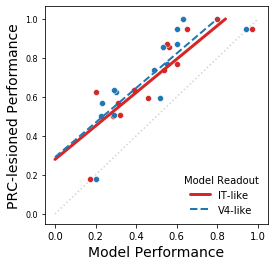

In [398]:
plt.figure(figsize=[4, 4])
_it_color = 'C3'
_v4_color = 'C0'
_params = {'edgecolor':'white', 'linewidth':.50}
_y = meta_df['prc_lesion'].values
_x = meta_df[it_layer].values
plt.scatter(y=_y,x=_x, facecolor=_it_color, **_params)
line_params = {'solid_capstyle':'round', 'linewidth':3}
_line = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
xs = np.array([0, min(1 , ( ( 1 - _line.intercept_[0] ) / _line.coef_[0] ))] ) 
plt.plot(xs, xs * _line.coef_[0] + _line.intercept_[0], color=_it_color, **line_params, label='IT-like')

_y = meta_df['prc_lesion'].values
_x = meta_df[v4_layer].values
plt.scatter(y=_y,x=_x, facecolor=_v4_color, **_params)
line_params = {'solid_capstyle':'round', 'linewidth':2, 'linestyle':'--'}
_line = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
xs = np.array([0, min(1 , ( ( 1 - _line.intercept_[0] ) / _line.coef_[0] ))] ) 
plt.plot(xs, xs * _line.coef_[0] + _line.intercept_[0], color=_v4_color, **line_params, label='V4-like')

plt.ylabel('PRC-lesioned Performance', fontsize=14)
plt.xlabel('Model Performance', fontsize=14)
plt.yticks(fontsize=8)
plt.plot([0, 1], [0, 1], zorder=-1, linestyle=':', color='lightgrey')
plt.legend(loc=4, framealpha=0, title='Model Readout') ; 

## Novel diagnostic experiment

In [246]:
with open('../yamins_2014/summaries.pkl', 'rb') as handle:
    summaries = pickle.load(handle)

In [247]:
_X = [] 
_Y = [] 
_L = [] 
_C = [] 
selected_categories = [ 'Faces', 'Planes', 'Chairs',   'Animals'] # list( summaries )# 
for i_category in list( summaries ): 
    for i_typical in summaries[i_category]: 
        for i_oddity in summaries[i_category][i_typical]: 
            _Y.append(np.mean(summaries[i_category][i_typical][i_oddity]['linear_accuracy']))
            _X.append(np.mean(summaries[i_category][i_typical][i_oddity]['distance_accuracy']))
            _L.append(i_typical)
            _C.append(i_category)

In [248]:
_unweighted_transform = LinearRegression().fit(np.reshape(_X, (-1,1)), np.reshape(_Y, (-1, 1)))

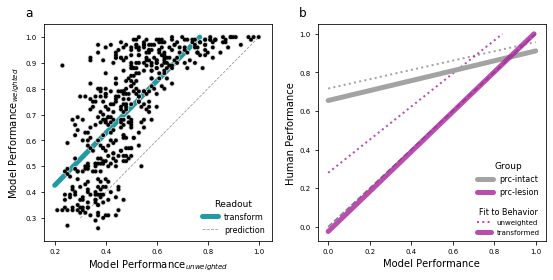

In [249]:
def plot_nice_line(model_, params={}, lim=0, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([lim, min(1 , ( ( 1 - b) / m ))])  
    plt.plot(xs, xs * m + b, **params)
        
lw = 5
label_size = 9
label_height = 1.03
label_dist = -.14

###
fig = plt.figure(figsize=[9,4])
ax = fig.add_subplot(121)
plt.scatter(x=_X, y=_Y, facecolor='lightgrey', edgecolor='', linewidth=0, s=30)
plt.scatter(x=_X, y=_Y, facecolor='black', edgecolor='', linewidth=.2, s=15)
plot_nice_line(_unweighted_transform, 
               {'linewidth':lw, 'alpha':1, 'color':'#229aa6', 'solid_capstyle': 'round', 'zorder':-5, 
                'label':'transform'}, 
               lim=.2)
[plt.scatter([], [], )]
#plt.legend()
prc_color = ('#a6229a', '#72249a') [0]
prc_old = '#b2b2b2'
hpc_color = '#a3a3a3'#('#032997', '#037397') [1]
#plt.plot([.3, .3], [.2, 1], linestyle=':', color='grey', linewidth=.5, zorder=-1)
#plt.plot([.2, 1], [.3, .3], linestyle=':', color='grey', linewidth=.5, zorder=-1, label='chance')
plt.xlabel(r'Model Performance$_{unweighted}$')
plt.ylabel(r'Model Performance$_{weighted}$')
plt.plot([.3, 1], [.3, 1], linestyle='--', color='grey', zorder=-3, label='prediction', linewidth=.8, alpha=.8)
plt.xticks(fontsize=7);
plt.yticks(fontsize=7);

plt.legend(framealpha=0, fontsize=8, title='Readout', title_fontsize=9)
ax.text(-0.05, 1.08, ['a','b','c'][0], transform=ax.transAxes,fontsize=12, va='top', ha='right')

    

ax = fig.add_subplot(122)
_x = meta_df[it_layer].values
_y = meta_df['prc_lesion'].values
linestyle = ':'


_model = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
plot_nice_line(_model, {'color':prc_color, 'linestyle':linestyle, 
                        'linewidth':lw-3, 'label':'unweighted', 'zorder':1, 'alpha':.8, 'solid_capstyle': 'round'})
transformed_x = [min(i[0], 1) for i in list(_unweighted_transform.predict(np.expand_dims(meta_df[it_layer], 1)))]

_model = LinearRegression().fit(np.reshape(transformed_x, (-1,1)), np.reshape(_y, (-1, 1)))
plot_nice_line(_model, {'color':prc_color, 'alpha':1, 'linewidth':lw,
                        'label':'transformed', 'alpha':.8, 'solid_capstyle': 'round', 'zorder':3})
transformed_legend = plt.legend(framealpha=0, loc=4, title='Fit to Behavior', title_fontsize=8, fontsize=7) 



_y = meta_df['prc_intact'].values
_model = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
plot_nice_line(_model, {'color':hpc_color, 'alpha':1, 'linewidth':lw-3, 'linestyle':linestyle, 
                        'zorder':-3, 'solid_capstyle': 'round'})
_model = LinearRegression().fit(np.reshape(transformed_x, (-1,1)), np.reshape(_y, (-1, 1)))

plot_nice_line(_model, {'color':hpc_color, 'alpha':.8,  'linewidth':lw, 
                        'alpha':1, 'zorder':2, 'solid_capstyle': 'round', })

plt.plot([0, 1], [0, 1], linestyle='--', color='grey', zorder=-3,)
plt.xlabel('Model Performance')
plt.ylabel('Human Performance')
plt.xticks(fontsize=7);
plt.yticks(fontsize=7);

ax.text(-0.05, 1.08, ['a','b','c'][1], transform=ax.transAxes,fontsize=12, va='top', ha='right')

# # Add first legend:  only labeled data is included
# leg1 = ax.legend(loc='lower left')
# # Add second legend for the maxes and mins.
# # leg1 will be removed from figure
# leg2 = ax.legend([maxline,minline],['max','min'], loc='upper right')
# # Manually add the first legend back
# ax.add_artist(leg1)

_a, = plt.plot([],[], **{'color':prc_color, 'alpha':.8, 'linewidth':lw,
                        'label':'transformed', 'solid_capstyle': 'round', 'zorder':-5})

_b, = plt.plot([],[], **{'color':hpc_color, 'alpha':1, 'linewidth':lw, 
                        'alpha':1, 'zorder':1, 'solid_capstyle': 'round'})


leg2 = ax.legend([_b,_a],['prc-intact', 'prc-lesion'], bbox_to_anchor=[1, .40], title='Group', 
                framealpha=0, title_fontsize=9, fontsize=8)

ax.add_artist( transformed_legend )
save_location = os.path.join(_location, 'weighted_unweighted_transform.pdf')
plt.savefig(save_location, format='pdf', bbox_inches = "tight")

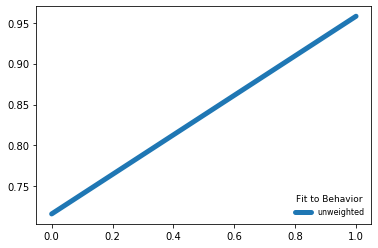

In [250]:
_model = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
plot_nice_line(_model, 
               {'fillstyle':None,'mfc':'black','mec':'black', 'linewidth':lw, 'label':'unweighted', 'zorder':1, 'solid_capstyle': 'round'})

transformed_x = [min(i[0], 1) for i in list(_unweighted_transform.predict(np.expand_dims(meta_df[it_layer], 1)))]
_model = LinearRegression().fit(np.reshape(transformed_x, (-1,1)), np.reshape(_y, (-1, 1)))
#plot_nice_line(_model, {'alpha':1, 'linewidth':lw, # prc_color
#                        'label':'transformed', 'alpha':1, 'solid_capstyle': 'round', 'zorder':-5})
transformed_legend = plt.legend(framealpha=0, loc=4, title='Fit to Behavior', title_fontsize=9, fontsize=8) 



_y = meta_df['prc_intact'].values
_model = LinearRegression().fit(np.reshape(_x, (-1,1)), np.reshape(_y, (-1, 1)))
#plot_nice_line(_model, { 'alpha':1, 'linewidth':lw, 
#                        'zorder':-3, 'solid_capstyle': 'round'})
_model = LinearRegression().fit(np.reshape(transformed_x, (-1,1)), np.reshape(_y, (-1, 1)))

#plot_nice_line(_model, {'color':hpc_color, 'alpha':1, 'linewidth':lw, 
#                        'alpha':1, 'zorder':1, 'solid_capstyle': 'round'})

In [251]:
transformed_x = [min(i[0], 1) for i in list(_unweighted_transform.predict(np.expand_dims(meta_df[it_layer], 1)))]
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((transformed_x, meta_df[it_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_lesion'])),
     'group': np.concatenate([np.repeat('lesion',n_), np.repeat('intact', n_)])})
prcinteraction = smf.ols("human ~ model + group", tmpdf).fit()
show_model_parameters(prcinteraction)[1]

1.4039010423364833e-09


'$R^{2}_{model} = 0.78$, $\\beta = 0.93$, $F(2, 25)$ = $9.28, p < 1 $ x $ 10 ^{-9} $'

In [252]:
tmpdf = pandas.DataFrame(
    {'model': np.concatenate((transformed_x, meta_df[it_layer])), 
     'human': np.concatenate((meta_df['prc_lesion'], meta_df['prc_lesion'])),
     'group': np.concatenate([np.repeat('transformed',n_), np.repeat('original', n_)])})
prcinteraction = smf.ols("human ~ model + group", tmpdf).fit()
show_model_parameters(prcinteraction, -2)[1]

0.00025528005808815596


'$R^{2}_{model} = 0.78$, $\\beta = -0.20$, $F(2, 25)$ = $-4.26, p < 2 $ x $ 10 ^{-4} $'

In [253]:
uniform = np.array(_X)
nonuniform = np.array(_Y)

In [254]:
print( np.mean(np.diff(uniform[uniform.argsort()])), min(uniform), max(uniform) ) 

0.001767337807606264 0.21 1.0


In [255]:
print( np.mean(np.diff(nonuniform[nonuniform.argsort()])), min(nonuniform), max(nonuniform))

0.0016554809843400448 0.26 1.0


In [256]:
selected_x = np.array([_X[i] for i in range(len(_X)) if _C[i] in selected_categories])
selected_y = np.array([_Y[i] for i in range(len(_X)) if _C[i] in selected_categories])

In [257]:
# print( np.mean(np.diff(selected_x[selected_x.argsort()])), min(selected_x), max(selected_x) ) 
# print( np.mean(np.diff(selected_y[selected_y.argsort()])), min(selected_y), max(selected_y) ) 

In [258]:
novel = pandas.read_csv('../../tasks/analysis/syn')

In [259]:
novel['delta_it_v4'] = novel['it']-novel['v4'] 
novel['delta_prc_it'] = novel['human']-novel['it'] 
novel['delta_fc6_v4'] = novel['fc6']-novel['v4'] 
novel['delta_prc_fc6'] = novel['human']-novel['fc6'] 

In [260]:
#novel_summary = novel.groupby(['typical_name']).mean()
novel_summary = pandas.DataFrame({
    'it': np.array([novel[novel.typical_name==o]['it'].mean()  for o in novel.typical_name.unique()]), 
    'v4': np.array([novel[novel.typical_name==o]['v4'].mean()  for o in novel.typical_name.unique()]),
    'fc6': np.array([novel[novel.typical_name==o]['fc6'].mean()  for o in novel.typical_name.unique()]),
    'prc': np.array([novel[novel.typical_name==o]['human'].mean()  for o in novel.typical_name.unique()]),
    'rt': np.array([np.round(novel[novel.typical_name==o]['rt'].mean()) for o in novel.typical_name.unique()]), 
    'object': np.array([o for o in novel.typical_name.unique()]),
    'category': [novel[novel.typical_name==o]['category'].iloc[0] for o in novel.typical_name.unique()]
})

novel_summary['delta_prc_it'] = novel_summary['prc']-novel_summary['it']
novel_summary['delta_prc_fc6'] = novel_summary['prc']-novel_summary['fc6'] 
novel_summary['delta_it_v4'] = novel_summary['it']-novel_summary['v4'] 
novel_summary['delta_prc_v4'] = novel_summary['prc']-novel_summary['v4'] 
novel_summary['delta_fc6_v4'] = novel_summary['fc6']-novel_summary['v4'] 

nN = len(novel_summary)

### IT outperforms V4

In [427]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_it_v4 ~ 1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

2.500469504937825e-07


$R^{2}_{model} = 0.00$, $\beta = 0.18$, $F(0, 31)$ = $6.56, p < 3 $ x $ 10 ^{-7} $

### PRC outperforms IT

In [426]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_prc_it ~ 1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

1.0718921764816792e-10


$R^{2}_{model} = 0.00$, $\beta = 0.24$, $F(0, 31)$ = $9.50, p < 1 $ x $ 10 ^{-10} $

### model predicts IT

In [263]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("it ~ fc6", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

3.873033964407894e-14


$R^{2}_{model} = 0.86$, $\beta = 0.81$, $F(1, 30)$ = $13.33, p < 4 $ x $ 10 ^{-14} $

### model outperforms V4

In [264]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_fc6_v4 ~ 1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

4.638095643840661e-09


$R^{2}_{model} = 0.00$, $\beta = 0.26$, $F(0, 31)$ = $8.02, p < 5 $ x $ 10 ^{-9} $

### PRC outperforms model

In [428]:
# test for interaction by patient group 
novel_itv4_delata = smf.ols("delta_prc_fc6~1", novel_summary).fit()
show_model_parameters(novel_itv4_delata)[0]

7.28512371498366e-06


$R^{2}_{model} = 0.00$, $\beta = 0.16$, $F(0, 31)$ = $5.38, p < 8 $ x $ 10 ^{-6} $

In [266]:
novel_interaction_data = pandas.DataFrame({
    'accuracy': np.concatenate([novel_summary['v4'],novel_summary['it'], novel_summary['prc']]), 
    'vvs_region': np.concatenate([np.repeat('v4', nN),np.repeat('it', nN), np.repeat('prc', nN)]), 
    'model': np.concatenate([novel_summary['fc6'],novel_summary['fc6'], novel_summary['fc6']]), 
})

In [267]:
# test for interaction by patient group 
novel_interaction_test = smf.ols("accuracy ~ vvs_region * model", novel_interaction_data).fit()
show_model_parameters(novel_interaction_test)[0]

1.4298562036181346e-09


$R^{2}_{model} = 0.90$, $\beta = -0.56$, $F(5, 90)$ = $-6.75, p < 1 $ x $ 10 ^{-9} $

In [430]:
rt_delta = smf.ols("zscore(it) ~ -1 + zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

2.16750357844648e-11


$R^{2}_{model} = 0.77$, $\beta = -0.88$, $F(1, 31)$ = $-10.16, p < 3 $ x $ 10 ^{-11} $

In [431]:
rt_delta = smf.ols("zscore(v4) ~ zscore(rt)-1", novel_summary).fit()
show_model_parameters(rt_delta)[0]

0.015795426175720852


$R^{2}_{model} = 0.17$, $\beta = -0.42$, $F(1, 31)$ = $-2.55, p < .05 $

In [500]:
rt_delta = smf.ols("zscore(delta_prc_it) ~ -1 + zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

1.591237174892438e-08


$R^{2}_{model} = 0.65$, $\beta = 0.81$, $F(1, 31)$ = $7.56, p < 2 $ x $ 10 ^{-8} $

In [439]:
rt_delta = smf.ols("zscore(delta_prc_v4) ~ zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

0.6823107883881426


$R^{2}_{model} = 0.01$, $\beta = -0.08$, $F(1, 30)$ = $-0.41, p > .05$

In [442]:
rt_delta = smf.ols("zscore(delta_prc_fc6) ~ -1 + zscore(rt)", novel_summary).fit()
show_model_parameters(rt_delta)[0]

2.7647211634132807e-06


$R^{2}_{model} = 0.51$, $\beta = 0.72$, $F(1, 31)$ = $5.72, p < 3 $ x $ 10 ^{-6} $

In [273]:
rt_delta = smf.ols("zscore(delta_prc_fc6) ~ zscore(rt)-1", novel_summary).fit()
show_model_parameters(rt_delta)[0]

2.7647211634132807e-06


$R^{2}_{model} = 0.51$, $\beta = 0.72$, $F(1, 31)$ = $5.72, p < 3 $ x $ 10 ^{-6} $

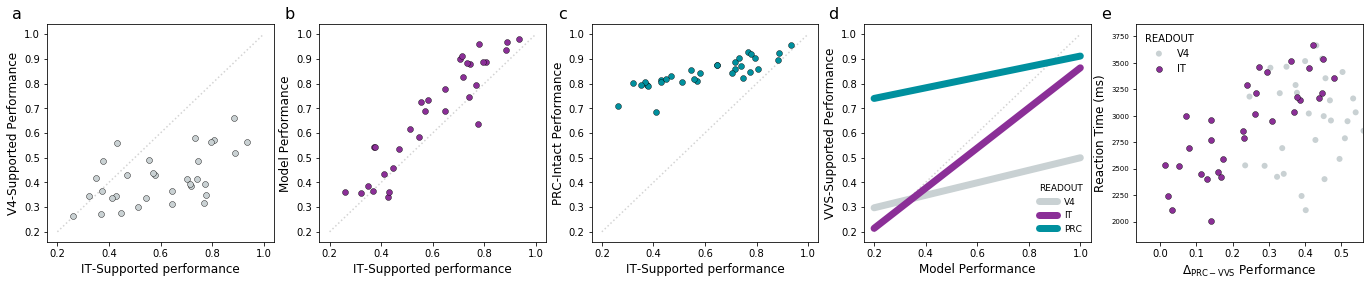

In [274]:
def plot_nice_line(model_, params={}, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([.2, min(1 , ( ( 1 - b) / m ))])  
    plt.plot(xs, xs * m + b, **params)
    
color = { 'v4':'#c9d1d3', 'fc6': '#8b2f97', 'prc': '#00909e'}

plt.figure(figsize=[17, 4])
for plot, region in enumerate(list(color), 1):
    
    ax = plt.subplot(1, 5, plot)
    #ax = fig.add_subplot(2,2,i+1)
    x_ = novel_summary['it'].values
    y_ = novel_summary[region].values
    plt.plot([.2, 1], [.2, 1], color='lightgrey', linestyle=':', zorder=-1)
    _dotparams = {'edgecolor':'black', 'linewidth': .4, 's':35, 'color':color[region]}
    plt.scatter(x=x_, y=y_, **_dotparams)
    plt.xlabel('IT-Supported performance', fontsize=12)
    if region == 'fc6': 
        plt.ylabel('Model Performance', fontsize=12)        
    elif region == 'prc': 
        plt.ylabel('PRC-Intact Performance', fontsize=12)      
    else: 
        plt.ylabel('%s-Supported Performance'%region.upper(), fontsize=12)
    
    ax.text(-0.11, 1.08, ['','a','b','c'][plot], transform=ax.transAxes,fontsize=16, va='top', ha='right')
        
    ax = plt.subplot(1, 5, 4)
    _lineparams = {'linewidth':7, 'zorder':-1, 'color':color[region], 'label':region.upper(), 
                   'solid_capstyle': 'round'}
    
    x_ = novel_summary['fc6'].values
    if region == 'fc6': 
        y_ = novel_summary['it'].values
        _lineparams['label']='IT'
    else: 
        y_ = novel_summary[region].values
        
    _model = LinearRegression().fit(np.reshape(x_, (-1,1)), np.reshape(y_, (-1, 1)))
    plot_nice_line(_model, _lineparams)

plt.ylabel('VVS-Supported Performance', fontsize=12)    
plt.xlabel('Model Performance', fontsize=12)
plt.plot([.2, 1], [.2, 1], color='lightgrey', linestyle=':', zorder=-3) 
plt.legend(loc=4, title='READOUT', framealpha=0, fontsize=9, title_fontsize=9) 
ax.text(-0.11, 1.08, 'd', transform=ax.transAxes,fontsize=16, va='top', ha='right')
ax = plt.subplot(155)
_dotparams = {'edgecolor':'black', 'linewidth': .4, 's':35}
_x = novel_summary['delta_prc_it']
_y = novel_summary['rt']
plt.scatter(x=novel_summary['delta_prc_v4'], y=_y, facecolor=color['v4'], edgecolor='', label='V4', zorder=-2)
plt.scatter(x=_x, y=_y, color=color['fc6'], **_dotparams, label='IT')
plt.ylim(min(_y)-200,  max(_y)+200)
plt.xlim(min(_x)-.08,  max(_x)+.08)
plt.legend(framealpha=0, title='READOUT') 
#plt.xlabel('PRC-intact — VVS-supported Accuracy', fontsize=12)
plt.xlabel('$\Delta_{\mathregular{PRC-VVS}}$'' Performance', fontsize=12)
plt.ylabel('Reaction Time (ms)', fontsize=12,)
plt.yticks(size=7)
plt.subplots_adjust(right=1.2)
ax.text(-0.11, 1.08, 'e', transform=ax.transAxes,fontsize=16, va='top', ha='right')

save_location = os.path.join(_location, 'novel_diagnostic_experiment.pdf')
plt.savefig(save_location, format='pdf', bbox_inches = "tight")

In [275]:
show_model_parameters(novel_interaction_test, -3)[0]

4.766297594726915e-24


$R^{2}_{model} = 0.90$, $\beta = 0.81$, $F(5, 90)$ = $13.86, p < 5 $ x $ 10 ^{-24} $

In [276]:
show_model_parameters(novel_interaction_test, -2)[0]

1.646813646255959e-10


$R^{2}_{model} = 0.90$, $\beta = -0.60$, $F(5, 90)$ = $-7.21, p < 2 $ x $ 10 ^{-10} $

In [277]:
show_model_parameters(novel_interaction_test)[0]

1.4298562036181346e-09


$R^{2}_{model} = 0.90$, $\beta = -0.56$, $F(5, 90)$ = $-6.75, p < 1 $ x $ 10 ^{-9} $

In [449]:
resnet_file = '/Users/biota/work/perirhinal_cortex/analysis/synthesis/resnet_results_across_layers.pickle'
with open(resnet_file, 'rb') as handle: 
    resnets = pickle.load(handle)
    for i_resnet in list(resnets): 
        meta_df['resnet_%s'%i_resnet] = [resnets[i_resnet][i] for i in meta_df.experiment.values]

### Fit to PRC-lesioned or -intact subjects doesn't change by increasing model depth

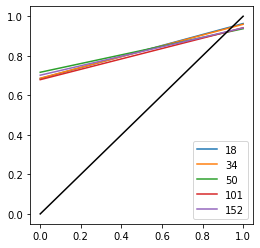

In [456]:
plt.figure(figsize=[4, 4])
resnet_test = pandas.DataFrame({}) #{'resnet':[], 'prc_intact':[], 'prc_lesion':[], 'layer':[]})
counter = 0
_singleMu = [] 
_singleBeta = [] 
for i_resnet in list(resnets): 
    _x = meta_df['resnet_%s'%i_resnet]
    _y = meta_df['prc_intact']
    _df = pandas.DataFrame({'model_performance':_x,
                            'prc_intact':_y,
                            'architecture': i_resnet,  
                            'linear': counter}) 
    
    resnet_test = pandas.concat([resnet_test, _df], ignore_index=True)
    counter+=1
    _singleMu.append( np.mean(np.sqrt((_y-_x)**2)) ) 
    _singleBeta.append( _model.coef_[0][0] )
    #plt.scatter(x=_x, y=_y)
    
    _model = LinearRegression().fit(np.reshape(_x.values, (-1,1)), 
                                    np.reshape(_y.values, (-1, 1)))
    
    plot_nice_line(_model,{'label':i_resnet})
plt.plot([0, 1], [0, 1], color='black')
plt.legend() 

In [457]:
show_model_parameters( 
    smf.ols('y~-1 + x', data=pandas.DataFrame({'x':_singleMu, 'y': np.arange(0, len(_singleMu))})).fit() )[1]

0.06243527917882048


'$R^{2}_{model} = 0.62$, $\\beta = 6.74$, $F(1, 4)$ = $2.56, p > .05$'

In [458]:
show_model_parameters( 
    smf.ols('y~-1 + x', data=pandas.DataFrame({'x':_singleBeta, 'y': np.arange(0, len(_singleMu))})).fit())[1]

0.05081874244523507


'$R^{2}_{model} = 0.66$, $\\beta = 7.76$, $F(1, 4)$ = $2.76, p > .05$'

In [459]:
resnet_ttest = smf.ols(formula = 'prc_intact ~ model_performance + linear', data=resnet_test).fit()
show_model_parameters(resnet_ttest)[0]

0.8090682824895875


$R^{2}_{model} = 0.31$, $\beta = -0.00$, $F(2, 67)$ = $-0.24, p > .05$

In [461]:
resnet_ttest.params

Intercept            0.699159
model_performance    0.252420
linear              -0.002061
dtype: float64

### All model depths demonstrate a significant interaction between PRC-lesioned and -intact subjects

In [462]:
resnet_test = pandas.DataFrame()
counter = 0
for i_resnet in list(resnets): 
    for i_group in ['prc_intact', 'prc_lesion']: 
        _df = pandas.DataFrame({'resnet':meta_df['resnet_%s'%i_resnet], 
                                'group':np.repeat([0,1][i_group=='prc_intact'], len(meta_df)),
                                'human':meta_df[i_group],
                                'architecture': np.repeat(i_resnet, len(meta_df))})
        resnet_test = pandas.concat([resnet_test, _df], ignore_index=True)

In [463]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='18']).fit()
show_model_parameters(_restest)[0]

0.002901196477721414


$R^{2}_{model} = 0.75$, $\beta = -0.51$, $F(3, 24)$ = $-3.32, p < 3 $ x $ 10 ^{-3} $

In [285]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='34']).fit()
show_model_parameters(_restest)[0]

0.005304111168779115


$R^{2}_{model} = 0.74$, $\beta = -0.45$, $F(3, 24)$ = $-3.07, p < 5 $ x $ 10 ^{-3} $

In [286]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='50']).fit()
show_model_parameters(_restest) [0]

0.0034342493487537146


$R^{2}_{model} = 0.71$, $\beta = -0.49$, $F(3, 24)$ = $-3.25, p < 3 $ x $ 10 ^{-3} $

In [287]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='101']).fit()
show_model_parameters(_restest) [0]

0.0012316810915163116


$R^{2}_{model} = 0.76$, $\beta = -0.56$, $F(3, 24)$ = $-3.66, p < 1 $ x $ 10 ^{-3} $

In [464]:
_restest = smf.ols(formula = 'human ~ resnet * group', data=resnet_test[resnet_test.architecture=='152']).fit()
show_model_parameters(_restest) [0]

0.0005613691049408029


$R^{2}_{model} = 0.78$, $\beta = -0.54$, $F(3, 24)$ = $-3.97, p < 6 $ x $ 10 ^{-4} $

In [289]:
def show_layer_benefit(meta_df): 
    def plot_nice_line(model_, params={}, title=''): 
        m, b = model_.coef_[0], model_.intercept_[0]
        xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
        plt.plot(xs, xs * m + b, **params)
        
    _annotate = False
    _layerselecttop = [] 
    _layerselectbot = [] 
    _earlycolor = '#ebb9e3'
    _latecolor = '#9a2487'
    
    for i_experiment in range(len(meta_df)): 

        y=meta_df[[i for i in layers]].iloc[i_experiment].values
        x=meta_df[[i for i in layers]].iloc[i_experiment].index.values
        i=np.arange(0, len(x))
        _model = smf.ols('performance~layer', data=pandas.DataFrame({'performance':y, 'layername':x, 'layer':i})).fit()

        _beta = _model.params[-1]
        _p = _model.pvalues[-1]
        _layerbenefit=(_p < (.05/len(meta_df))) * (_beta>0)

        if _layerbenefit: 
            _style = '-'
            _pointparams = {'s':15, 'alpha':1, 'edgecolor':'black', 'facecolor':'white', 'linewidth':.5, 'linestyle':'-'}
            _model = max(y)
        else:  
            _style = ':'
            _pointparams = {'s':20,'facecolor':'grey', 'edgecolor':'white', 'linewidth':.3, 'linestyle':'-'}
            _model = meta_df[it_layer].iloc[i_experiment]

 
        _prc = meta_df['prc_lesion'].iloc[i_experiment]
        plt.scatter(x=_model,y=_prc, **_pointparams)
        
        
        if _annotate: plt.annotate(meta_df['experiment'][i_experiment], xy=(_model, _prc), fontsize=5)

        if _layerbenefit: 
            plt.plot([min(y), max(y)], [_prc, _prc], color='grey', linestyle='--', alpha=.4, zorder=-2, linewidth=.3)
            plt.scatter(x=min(y),y=_prc, color='black', s=.5)
            if _annotate: plt.annotate(argmin(y), xy=(min(y), _prc), fontsize=5)
        _layerselectbot.append(min(y[:len(y)//2]))    
        _layerselecttop.append(max(y[len(y)//2:]))
        

    _params ={'color':_latecolor, 'linewidth':5, 'solid_capstyle':'round'}
    _model = LinearRegression().fit(np.reshape(_layerselecttop, (-1,1)), 
                                    np.reshape(meta_df['prc_lesion'].values, (-1, 1)))
    
    plot_nice_line(_model, _params)
    _params ={'color':_latecolor, 'linewidth':5, 'solid_capstyle':'round'}
    plt.scatter(x=_layerselecttop,y=meta_df['prc_lesion'], facecolor=_latecolor, zorder=3, edgecolor='', alpha=.3)

    _params ={'color':_earlycolor, 'linewidth':5, 'solid_capstyle':'round', 'zorder':-1}
    _model = LinearRegression().fit(np.reshape(_layerselecttop, (-1,1)), 
                                    np.reshape(meta_df['prc_lesion'].values, (-1, 1)))
    plot_nice_line(_model, _params)
    _params ={'color':_earlycolor, 'linewidth':5, 'solid_capstyle':'round'}
    plt.scatter(x=_layerselecttop,y=meta_df['prc_lesion'], facecolor=_latecolor, zorder=-3, edgecolor='', alpha=.3)

    plt.plot([0, 1], [0, 1], linestyle=':', alpha=.3, color='grey')
    save_location = os.path.join(_location, 'layer_benifit.pdf')
    plt.xlabel('$Model_{original}$ $Performance$', fontsize=12, labelpad=10)
    plt.ylabel('Human$_{prc.lesion}$ Performance', fontsize=12, labelpad=5)
    plt.xticks(size=8)
    plt.yticks(size=8)
    return _layerselecttop, _layerselectbot

In [290]:
def show_resnets(df):
    

    def plot_nice_line(model_, params={}, title=''): 
        m, b = model_.coef_[0], model_.intercept_[0]
        xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
        plt.plot(xs, xs * m + b, **params)
        
    prc_color = ('#a6229a', '#72249a') 
    con_color = ('#d8d8d8', '#b2b2b2')   
    hpc_color = ('#032997', '#037397') 
    
    lw = 3
    _a = 1 
    _cap = ['butt', 'round', 'projecting'][0]
    _jstyle = ['miter', 'round', 'bevel'][2]
    resnets = [i for i in meta_df.columns if 'resnet' in i]
    prc_c = [i.rgb for i in colour.Color(prc_color[0]).range_to(colour.Color(prc_color[1]), len(resnets))]
    hpc_c = [i.rgb for i in colour.Color(hpc_color[0]).range_to(colour.Color(hpc_color[1]), len(resnets))]
    con_c = [i.rgb for i in colour.Color(con_color[0]).range_to(colour.Color(con_color[1]), len(resnets))]

    prc_ = df['prc_lesion'].values
    hpc_ = df['hpc_lesion'].values
    con_ = df['prc_intact'].values
    
    for i_resnet in range(len(resnets)): 
        
        mod_ = df[resnets[i_resnet]].values

        con_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_, (-1, 1)))
        params = {'color':con_c[i_resnet],'linewidth':lw,'zorder':-10, 
                 'solid_capstyle':_cap, 'alpha':_a, 'solid_joinstyle':_jstyle}
        plot_nice_line(con_model_, params)

        hpc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(hpc_, (-1, 1)))
        params = {'color':hpc_c[i_resnet], 'linewidth':lw,'zorder':-3, 
                 'solid_capstyle':_cap, 'alpha':_a}
        plot_nice_line(hpc_model_, params)

        prc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(prc_, (-1, 1)))
        params = {'color':prc_c[i_resnet], 'linewidth':lw, 'zorder':-5, 'label':'%3d'%int(resnets[i_resnet][7:]), 
                 'solid_capstyle':_cap, 'alpha':_a}
        plot_nice_line(prc_model_, params)
    
    
    y_i = .0085
    y_x = .0595
    ly = .29
    _params = {'solid_capstyle':_cap,'linewidth':lw}
    # PRC ANNOTATION
    plt.annotate('$PRC$', xy=(.825, ly), fontsize=9)
    # HPC ANNOTATION
    [plt.plot([.71, .79],[y_i + y_x*i, y_i+y_x*i], color=hpc_c[i], **_params) for i in range(len(resnets))]
    plt.annotate('$HPC$', xy=(.715, ly), fontsize=9)
    # PRC INTACT
    [plt.plot([.60, .68],[y_i + y_x*i, y_i+y_x*i], color=con_c[i], **_params) for i in range(len(resnets))]
    plt.annotate('$NON$', xy=(.59, ly), fontsize=9)
    plt.annotate('$n$', xy=(.96, ly), fontsize=9)
    plt.annotate('Lesion Group', xy=(.62, .37), fontsize=10)
    plt.plot([0, 1], [0, 1], color='grey', linestyle=':', zorder=-15)
    plt.legend(title='', framealpha=0, fontsize=8, loc=4)
    plt.xlabel('Model$_{layers=n} $'' ''Performance', fontsize=12, labelpad=10)
    plt.ylabel('Human Performance', fontsize=12)
    plt.xticks(size=8)
    plt.yticks(size=8)

In [291]:
def show_layer_benefit(fig): 
    def plot_nice_line(model_, params={}, title=''): 
        m, b = model_.coef_[0], model_.intercept_[0]
        xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
        plt.plot(xs, xs * m + b, **params)
    _layerbenefit = [] 
    _layerselectbot = [] 
    _layerselecttop = [] 
    # ('#72249a', '#9a2487') 
    _earlycolor = '#a6229a'#'#a6229a'#'#9a2487' 
    _latecolor = '#72249a'#'#72249a'
    _size = 15
    _pointlw = .5
    _lw = 4
    for i_experiment in range(len(meta_df)): 

        y=meta_df[[i for i in layers]].iloc[i_experiment].values
        x=meta_df[[i for i in layers]].iloc[i_experiment].index.values

        _m = smf.ols('performance~layer', data=pandas.DataFrame({'performance':y,'layer':np.arange(0, len(x))})).fit()
        _layerbenefit.append((_m.pvalues[-1] < (.05/len(meta_df))) * (_m.params[-1]>0))
        _layerselectbot.append(min(y[:len(y)//2]))    
        _layerselecttop.append(max(y[len(y)//2:]))
    
        #a = show_model_parameters(_m)[1]
        #print( meta_df['experiment'].iloc[i_experiment], show_model_parameters(_m)[1])

    _human = meta_df['prc_lesion'].values

    _layerselectbot = meta_df['conv2_1'].values
    _layerselecttop = meta_df['fc6'].values
    
    plt.scatter(x=_layerselectbot,y=_human,
                facecolor=[['white', _earlycolor][i] for i in _layerbenefit],
                edgecolor=[[_earlycolor, 'white'][i] for i in _layerbenefit], 
                linewidth=_pointlw, s=_size, 
                zorder=5
               )

    _model = LinearRegression().fit(np.reshape(_layerselectbot, (-1,1)), np.reshape(_human, (-1, 1)))
    _params ={'color':_earlycolor, 'alpha':1, 
              'linewidth':_lw, 'label':'Early$_{conv2\_1}$', 'linestyle':'-'} # 'solid_capstyle':'round'    
    plot_nice_line(_model, _params)


    plt.scatter(x=_layerselecttop,y=_human,
               facecolor=[['white', _latecolor][i] for i in _layerbenefit],
               edgecolor=[[_latecolor, 'white'][i] for i in _layerbenefit], 
               zorder=5, #[[-2, 2][i] for i in _layerbenefit], 
               linewidth=_pointlw, s=_size)

    _params ={'color':_latecolor, 'linewidth':_lw, 'label':'Late$_{fc6}$', 'linestyle':'-',  'alpha':1, } 
    _model = LinearRegression().fit(np.reshape(_layerselecttop, (-1,1)), np.reshape(_human, (-1, 1)))
    plot_nice_line(_model, _params)

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=.5)
    leg1 = ax.legend(title='Layer Used as Readout for \n    Model Performance', framealpha=0, bbox_to_anchor=[.96, .2,],
                     title_fontsize=8, fontsize=7, ncol=2,) 
    plt.xlabel('$Model_{architecture=original}$ $Performance$', fontsize=12, labelpad=10)
    plt.ylabel('$Human_{prc.lesion}$ $Performance$', fontsize=12, labelpad=5)
    plt.xticks(size=8)
    plt.yticks(size=8)
    
    a = plt.scatter(x=[],y=[],facecolor=_latecolor, edgecolor='white', linewidth=_pointlw, s=_size)
    b = plt.scatter(x=[],y=[],facecolor='white', edgecolor=_latecolor, linewidth=_pointlw, s=_size) 
    
    # Add first legend:  only labeled data is included
    #leg1 = ax.legend(loc='lower left')
    # Add second legend for the maxes and mins.
    # leg1 will be removed from figure
    leg2 = ax.legend([a,b],['Yes','No'], framealpha=0, title_fontsize=8, fontsize=7, loc=2, # bbox_to_anchor=[.96, .34,], 
                     title='Depth Improves\n  Performance',  ncol=2,
                    columnspacing=.2)
    # Manually add the first legend back
    ax.add_artist(leg1)

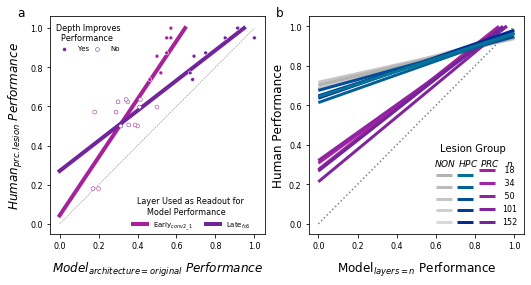

In [292]:
fig = plt.figure(figsize=[8.5, 4])
ax = fig.add_subplot(121)
plt.text(-.15, 1, 'a', fontsize=12, transform=ax.transAxes,)
show_layer_benefit(ax) 
ax = fig.add_subplot(122)
show_resnets(meta_df)
plt.text(-.15, 1, 'b', fontsize=12, transform=ax.transAxes,)
plt.savefig(os.path.join(_location, 'layer_analyses.pdf'), format='pdf', bbox_inches = "tight")

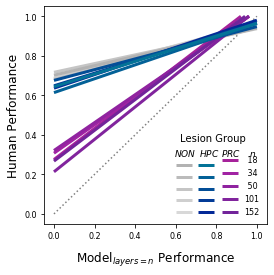

In [293]:
fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)
show_resnets(meta_df)
#plt.text(-.15, 1, 'b', fontsize=12, transform=ax.transAxes,)
plt.savefig(os.path.join(_location, 'multiple_resnets.pdf'), format='pdf', bbox_inches = "tight")

In [476]:
_improved = [] 
_static = [] 

for i_experiment in range(len(meta_df)): 
    y=meta_df[[i for i in layers]].iloc[i_experiment].values
    x=meta_df[[i for i in layers]].iloc[i_experiment].index.values

    _m = smf.ols('performance~layer', data=pandas.DataFrame({'performance':zscore(y),'layer':np.arange(0, len(x))})).fit()
    if (_m.pvalues[-1] < (.05/len(meta_df))) * (_m.params[-1]>0): 
        print('----', meta_df['experiment'][i_experiment],show_model_parameters( _m ) [1])
        _improved.append( meta_df['prc_lesion'].iloc[i_experiment] )
    else: 
        _static.append( meta_df['prc_lesion'].iloc[i_experiment] )
        print('xxxxx', meta_df['experiment'][i_experiment], show_model_parameters( _m ) [1])
        

0.01670626441558391
xxxxx faces $R^{2}_{model} = 0.27$, $\beta = 0.09$, $F(1, 19)$ = $2.62, p < .05 $
6.234905103779689e-06
---- snow3 $R^{2}_{model} = 0.67$, $\beta = 0.13$, $F(1, 19)$ = $6.17, p < 7 $ x $ 10 ^{-6} $
5.490769388574858e-07
---- snow4 $R^{2}_{model} = 0.74$, $\beta = 0.14$, $F(1, 19)$ = $7.37, p < 6 $ x $ 10 ^{-7} $
0.9548903825052009
xxxxx snow5 $R^{2}_{model} = 0.00$, $\beta = 0.00$, $F(1, 19)$ = $0.06, p > .05$
0.9594748756270006
xxxxx familiar_high $R^{2}_{model} = 0.00$, $\beta = -0.00$, $F(1, 19)$ = $-0.05, p > .05$
3.0204123750427537e-11
---- familiar_low $R^{2}_{model} = 0.91$, $\beta = 0.16$, $F(1, 19)$ = $13.61, p < 3 $ x $ 10 ^{-11} $
0.0036836597442902446
xxxxx novel_high $R^{2}_{model} = 0.37$, $\beta = -0.10$, $F(1, 19)$ = $-3.31, p < 4 $ x $ 10 ^{-3} $
1.2516536694173822e-05
---- novel_low $R^{2}_{model} = 0.64$, $\beta = 0.13$, $F(1, 19)$ = $5.84, p < 2 $ x $ 10 ^{-5} $
0.00032336475767888
xxxxx faces_E1 $R^{2}_{model} = 0.50$, $\beta = -0.12$, $F(1, 19)

In [466]:
md(r'$\mu_{prc.improved}=%.02f, \mu_{prc.unimproved}=%.02f$'%(np.mean( _improved ), np.mean(_static)))

$\mu_{prc.improved}=0.88, \mu_{prc.unimproved}=0.52$

In [469]:
stats.ttest_ind(_improved, _static, equal_var=False,)

Ttest_indResult(statistic=5.1627012670898385, pvalue=0.0004223693314892628)

In [468]:
_df = pandas.DataFrame({'model': np.array([meta_df['conv2_1'].values, meta_df['fc6'].values]).flatten(), 
                        'human': np.array([meta_df['prc_lesion'].values, meta_df['prc_lesion'].values]).flatten(), 
                        'tag': np.array([np.repeat(0, len(meta_df)), np.repeat(1, len(meta_df))]).flatten()})
show_model_parameters(smf.ols(formula = 'human ~ model * tag', data=_df).fit())[0]

0.01307173962249376


$R^{2}_{model} = 0.78$, $\beta = -0.71$, $F(3, 24)$ = $-2.68, p < .05 $

In [298]:
_df = pandas.DataFrame({'delta': np.array([meta_df['prc_lesion'].values-meta_df['conv2_1'].values,
                                           meta_df['prc_lesion'].values-meta_df['fc7'].values]).flatten(), 
                        'layer': np.array([np.repeat(0, len(meta_df)), np.repeat(1, len(meta_df))]).flatten()})
show_model_parameters(smf.ols(formula = 'delta ~ layer', data=_df).fit())[0]

0.019176607318673832


$R^{2}_{model} = 0.19$, $\beta = -0.12$, $F(1, 26)$ = $-2.50, p < .05 $

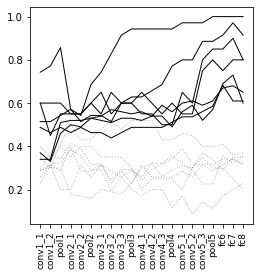

In [299]:
plt.figure(figsize=[4, 4])
for e in range(len(meta_df)): 

    _l = pandas.DataFrame({'y':(meta_df.iloc[e][layers].values).astype('float64'),
                           'x':np.arange(0, len(layers))})
    
    _m = smf.ols('y~x', data=_l).fit()
    _depthbenifit = (_m.pvalues[-1] < (.05/len(meta_df))) * (_m.params[-1]>0)
    
    if _depthbenifit: 
        _alpha = 1
        _linestyle = '-'
    else: 
        _alpha = .3
        _linestyle = ':'
        
    _lwidth = 1 
    
    plt.plot(_l['y'], color='black', alpha=_alpha, linewidth=_lwidth, linestyle=_linestyle)
plt.xticks(range(len(layers)), layers, rotation=90, size=9);

### FACE ANALYSES

In [509]:
vggface_retrospective = '/Users/biota/work/perirhinal_cortex/analysis/synthesis/vggface_fc6_metaanalysis.pickle'
with open(vggface_retrospective, 'rb') as handle: 
    vgg_face = pickle.load(handle)
    meta_df['vggface'] = [vgg_face[i] for i in meta_df.experiment.values]
    meta_df['isface'] = ['face' in i for i in meta_df.experiment.values]
meta_face = meta_df[meta_df['isface']]
meta_objects = meta_df[meta_df['isface']==False]

In [510]:
_facenovel = '~/work/perirhinal_cortex/analysis/yamins_2014/foveating_stimuli/novel_diagnostic_experimental_data.csv'
df_select = pandas.read_csv(_facenovel)
_f = df_select

foveated_items = pandas.DataFrame({ 
    'human': _f[_f.model=='human'].accuracy.values, 
    'time': _f[_f.model=='human'].reaction_time.values,
    'imagenet':_f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='imagenet')].accuracy.values,
    'vggface': _f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='vggface')].accuracy.values,
    'it': _f[(_f.model=='it')].accuracy.values, 
    'category': _f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='vggface')].category.values, 
    'typical_name': _f[(_f.model=='vgg16')*(_f.image_type=='foveated')*(_f.training_data=='vggface')].typical_name.values
})

novel_objects = foveated_items[foveated_items.category!='faces']
novel_faces = foveated_items[foveated_items.category=='faces']

### Faces are "complex": PRC-intact subjects outperform -lesioned subjects, models, and IT

###  meta-analysis

In [511]:
_facetest = pandas.DataFrame({'delta':meta_face['prc_intact']-meta_face['prc_lesion']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_facetest).fit())[0]

0.023889115788641366


$R^{2}_{model} = 0.00$, $\beta = 0.20$, $F(0, 3)$ = $4.25, p < .05 $

In [512]:
_facetest = pandas.DataFrame({'delta':meta_face['prc_intact']-meta_face['fc6']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_facetest).fit())[0]

0.0026901066089057243


$R^{2}_{model} = 0.00$, $\beta = 0.47$, $F(0, 3)$ = $9.23, p < 3 $ x $ 10 ^{-3} $

### novel-analysis

In [513]:
_ttestface = pandas.DataFrame({'delta':novel_faces['human']-novel_faces['imagenet']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

1.7311589403237252e-20


$R^{2}_{model} = -0.00$, $\beta = 0.37$, $F(0, 46)$ = $16.06, p < 2 $ x $ 10 ^{-20} $

In [514]:
_ttestface = pandas.DataFrame({'delta':novel_faces['human']-novel_faces['it']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

1.93746335855824e-20


$R^{2}_{model} = 0.00$, $\beta = 0.41$, $F(0, 46)$ = $16.02, p < 2 $ x $ 10 ^{-20} $

### face training increases performance on faces

In [515]:
_ttestface = pandas.DataFrame({'delta':meta_face['vggface']-meta_face['fc6']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

0.006734755185490587


$R^{2}_{model} = -0.00$, $\beta = 0.35$, $F(0, 3)$ = $6.72, p < 7 $ x $ 10 ^{-3} $

In [521]:
_ttestface = pandas.DataFrame({'delta':novel_faces['vggface']-novel_faces['imagenet']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[1]

8.737742518033274e-15


'$R^{2}_{model} = -0.00$, $\\beta = 0.33$, $F(0, 46)$ = $11.24, p < 9 $ x $ 10 ^{-15} $'

### Model Performance is statistically indistinguishable for PRC-intact behavior

In [517]:
_ttestface = pandas.DataFrame({'delta':meta_face['prc_intact']-meta_face['vggface']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

0.31247583927258993


$R^{2}_{model} = 0.00$, $\beta = 0.11$, $F(0, 3)$ = $1.21, p > .05$

In [518]:
_ttestface = pandas.DataFrame({'delta':novel_faces['human']-novel_faces['vggface']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[0]

0.20542337320800372


$R^{2}_{model} = -0.00$, $\beta = 0.04$, $F(0, 46)$ = $1.28, p > .05$

### face-trained models perform worse on non-faces

In [489]:
_facetest = pandas.DataFrame({'delta':meta_objects['vggface']-meta_objects['fc6']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_facetest).fit())[0]

0.046794855464919724


$R^{2}_{model} = 0.00$, $\beta = -0.12$, $F(0, 9)$ = $-2.30, p < .05 $

In [523]:
_ttestface = pandas.DataFrame({'delta':novel_objects['imagenet']-novel_objects['vggface']})
show_model_parameters(smf.ols(formula = 'delta ~ 1', data=_ttestface).fit())[1]

1.5298644535061567e-13


'$R^{2}_{model} = 0.00$, $\\beta = 0.15$, $F(0, 167)$ = $8.04, p < 2 $ x $ 10 ^{-13} $'

### significant interaction between training and testing performance, as a function of stimulus type

In [524]:
retro_test = pandas.DataFrame({'human': np.array([meta_df['prc_lesion'], meta_df['prc_lesion']]).flatten(), 
                               'model': np.array([meta_df['vggface'], meta_df['fc6']]).flatten(), 
                               'face': np.array([meta_df.isface==False, meta_df.isface==False]).flatten(), 
                               'type': np.array([np.repeat(0, len(meta_df)), np.repeat(1, len(meta_df))]).flatten()})

novel_test = pandas.DataFrame({
    'human': np.array([foveated_items['human'], foveated_items['human']]).flatten(), 
    'model': np.array([foveated_items['vggface'], foveated_items['imagenet']]).flatten(), 
    'face': np.array([foveated_items.category=='faces', foveated_items.category=='faces']).flatten(), 
    'type': np.array([np.repeat(0, len(foveated_items)), np.repeat(1, len(foveated_items))]).flatten()})

In [525]:
stats.ttest_rel(meta_df[meta_df.isface == True]['vggface'].values, 
                meta_df[meta_df.isface == True][it_layer].values) 

Ttest_relResult(statistic=7.91715350205103, pvalue=0.004201133532817599)

In [526]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=retro_test).fit()
show_model_parameters(_ttestface)[0]

0.01052553437667199


$R^{2}_{model} = 0.27$, $\beta = 0.47$, $F(3, 24)$ = $2.77, p < .05 $

In [527]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=novel_test).fit()
show_model_parameters(_ttestface)[0]

5.795337189424493e-20


$R^{2}_{model} = 0.20$, $\beta = -0.48$, $F(3, 426)$ = $-9.62, p < 6 $ x $ 10 ^{-20} $

In [505]:
show_model_parameters(smf.ols(formula = 'human ~ model + face *  type', data=retro_test).fit(), -2) [0]

0.004693417617607256


$R^{2}_{model} = 0.71$, $\beta = 0.32$, $F(4, 23)$ = $3.13, p < 5 $ x $ 10 ^{-3} $

In [317]:
_ttestface = smf.ols(formula = 'human ~ model + face *  type', data=novel_test).fit()
show_model_parameters(_ttestface)[0]

0.020642020550835267


$R^{2}_{model} = 0.26$, $\beta = 0.05$, $F(4, 425)$ = $2.32, p < .05 $

In [318]:
_ttestface = smf.ols(formula = 'model ~ face *  type', data=novel_test).fit()
show_model_parameters(_ttestface)[0]

5.795337189424493e-20


$R^{2}_{model} = 0.20$, $\beta = -0.48$, $F(3, 426)$ = $-9.62, p < 6 $ x $ 10 ^{-20} $

In [319]:
novel_item_summary = foveated_items.groupby('typical_name').mean()

In [320]:
novel_item_summary['delta_humanimagenet'] = novel_item_summary['human'] -  novel_item_summary['imagenet']  
novel_item_summary['delta_humanit'] = novel_item_summary['human'] -  novel_item_summary['it']  
novel_item_summary['delta_humanvggface'] = novel_item_summary['human'] -  novel_item_summary['vggface']  

In [321]:
_ttestface = smf.ols(formula = 'it ~ vggface', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

0.8477408735442021


$R^{2}_{model} = 0.00$, $\beta = -0.05$, $F(1, 30)$ = $-0.19, p > .05$

In [322]:
_ttestface = smf.ols(formula = 'it ~ imagenet', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

4.070382240310681e-10


$R^{2}_{model} = 0.73$, $\beta = 0.84$, $F(1, 30)$ = $9.09, p < 4 $ x $ 10 ^{-10} $

In [528]:
_ttestface = smf.ols(formula = 'zscore(time) ~ zscore(vggface)', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

0.21076906665361342


$R^{2}_{model} = 0.05$, $\beta = -0.23$, $F(1, 30)$ = $-1.28, p > .05$

In [529]:
_ttestface = smf.ols(formula = 'zscore(time) ~ zscore(imagenet)', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

1.1348570629549994e-07


$R^{2}_{model} = 0.61$, $\beta = -0.78$, $F(1, 30)$ = $-6.91, p < 2 $ x $ 10 ^{-7} $

In [325]:
_ttestface = smf.ols(formula = 'time ~ delta_humanit', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

1.1864012291756243e-06


$R^{2}_{model} = 0.55$, $\beta = 2482.33$, $F(1, 30)$ = $6.06, p < 1 $ x $ 10 ^{-6} $

In [326]:
_ttestface = smf.ols(formula = 'time ~ delta_humanimagenet', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

5.033796458698187e-05


$R^{2}_{model} = 0.43$, $\beta = 2072.57$, $F(1, 30)$ = $4.73, p < 5 $ x $ 10 ^{-5} $

In [327]:
_ttestface = smf.ols(formula = 'time ~ delta_humanvggface', data=novel_item_summary ).fit()
show_model_parameters(_ttestface)[0]

0.4243315219205336


$R^{2}_{model} = 0.02$, $\beta = -442.14$, $F(1, 30)$ = $-0.81, p > .05$

In [328]:
_facenovel = '~/work/perirhinal_cortex/analysis/yamins_2014/foveating_stimuli/novel_diagnostic_experimental_data.csv'
df_select = pandas.read_csv(_facenovel)
_f = df_select

original_items = pandas.DataFrame({ 
    'human': _f[_f.model=='human'].accuracy.values, 
    'time': _f[_f.model=='human'].reaction_time.values,
    'imagenet':_f[(_f.model=='vgg16')*(_f.image_type=='original')*(_f.training_data=='imagenet')].accuracy.values,
    'vggface': _f[(_f.model=='vgg16')*(_f.image_type=='original')*(_f.training_data=='vggface')].accuracy.values,
    'it': _f[(_f.model=='it')].accuracy.values, 
    'category': _f[(_f.model=='vgg16')*(_f.image_type=='original')*(_f.training_data=='vggface')].category.values, 
    'typical_name': _f[(_f.model=='vgg16')*(_f.image_type=='original')*(_f.training_data=='vggface')].typical_name.values
})

novel_objects_original = original_items[original_items.category!='faces']
novel_faces_original = original_items[original_items.category=='faces']


print('df: %d'%(len(novel_objects_original)-1), 
      stats.ttest_rel(novel_objects_original['imagenet'], novel_objects_original['vggface']))

print('df: %d'%(len(novel_faces_original)-1), 
      stats.ttest_rel(novel_faces_original['imagenet'], novel_faces_original['vggface']))

original_item_summary = original_items.groupby('typical_name').mean()

original_item_summary['delta_humanimagenet'] = original_item_summary['human'] -  original_item_summary['imagenet']  
original_item_summary['delta_humanit'] = original_item_summary['human'] -  original_item_summary['it']  
original_item_summary['delta_humanvggface'] = original_item_summary['human'] -  original_item_summary['vggface']  

df: 167 Ttest_relResult(statistic=10.697390292178861, pvalue=1.1363981522233928e-20)
df: 46 Ttest_relResult(statistic=0.6351861678451385, pvalue=0.5284541529804228)


In [329]:
_ttestface = smf.ols(formula = 'human ~ vggface', data=original_item_summary ).fit()
show_model_parameters(_ttestface)[1]

0.0916074602533538


'$R^{2}_{model} = 0.09$, $\\beta = 0.30$, $F(1, 30)$ = $1.74, p > .05$'

In [330]:
_ttestface = smf.ols(formula = 'it ~ vggface', data=original_item_summary ).fit()
show_model_parameters(_ttestface)[1]

0.28364047272907017


'$R^{2}_{model} = 0.04$, $\\beta = 0.58$, $F(1, 30)$ = $1.09, p > .05$'

In [331]:
_ttestface = smf.ols(formula = 'time ~ vggface', data=original_item_summary ).fit()
show_model_parameters(_ttestface)[1]

0.36831859388338994


'$R^{2}_{model} = 0.03$, $\\beta = -1202.72$, $F(1, 30)$ = $-0.91, p > .05$'

In [332]:
def face_retrospective_models(PARAMS): 
    np.random.seed(1234)
    con_color =  ('#2a2a2a', '#cccccc')
    n_objects = sum(['face' not in i for i in meta_df.experiment])
    c_objects = [i.rgb for i in colour.Color(con_color[1]).range_to(colour.Color(con_color[0]), n_objects)]
    c_faces = PARAMS['FACECOLOR']
    s_ = PARAMS['s'] + 5
    x0 = .1
    x1 = .9
    #lw = PARAMS['pointlinewidth']+.25
    _params = {'edgecolor':PARAMS['edgecolor'], 's':PARAMS['s'], 'linewidth':PARAMS['pointlinewidth']}
    
    i_df = meta_df[ ['face' in i for i in meta_df.experiment] ] 
    plt.scatter(x=[x1+np.random.randn()/100 for i in range(len(i_df))],y=i_df['vggface'],
                facecolor=c_faces, **_params)
    plt.scatter(x=[x0+np.random.randn()/100 for i in range(len(i_df))],y=i_df['fc6'],
                facecolor=c_faces, **_params)
    faces_ = [i_df['vggface'].mean(), i_df['fc6'].mean()]

    _params = {'edgecolor':'white', 's':s_, 'linewidth':PARAMS['pointlinewidth'], 'zorder':-2}
    i_df = meta_df[ ['face' not in i for i in meta_df.experiment] ] 
    plt.scatter(x=[x1+np.random.randn()/100 for i in range(len(i_df))],y=i_df['vggface'],
                facecolor=c_objects, **_params)
    plt.scatter(x=[x0+np.random.randn()/100 for i in range(len(i_df))],y=i_df['fc6'],
                facecolor=c_objects, **_params)
    objects_ = [i_df['vggface'].mean(), i_df['fc6'].mean()]

    _params = {'linewidth':2, 'zorder':-5, 'linestyle':'-', 'alpha':1, 'solid_capstyle':'round'}
    plt.plot([x0, x1], [faces_[0], objects_[0]], color='grey', **_params, label='object') 
    plt.plot([x0, x1], [faces_[1], objects_[1]], color=c_faces, **_params, label='faces')
    plt.xlim(-.2, 1.2)
    #plt.ylim(.01, 1.15)
    plt.ylim([.05, 1.05])
    plt.xticks([x0, x1], ['Objects', 'Faces'], fontsize=PARAMS['xtick_size']+2, y=0,)
    plt.ylabel('Model Performance on Retrospective Experiments', labelpad=5, 
               fontsize=PARAMS['ylabel_fontsize']+2); 
    plt.yticks(fontsize=PARAMS['xtick_size'])
    plt.xlabel('Training Data', labelpad=5, fontsize=PARAMS['xlabel_fontsize']+2)
    plt.legend(title='category mean', framealpha=0, fontsize=PARAMS['legend_fontsize'], 
               labelspacing=.2, bbox_to_anchor=[.25, .2], title_fontsize=PARAMS['legend_title_fontsize'])

In [333]:
def face_retrospective_human(ax, PARAMS, group, model, show_legend=1): 
    #prc_color = ('#72249a', '#9a2487') 
    con_color =  ('#2a2a2a', '#cccccc')
    #hpc_color = ('#032997', '#037397') 

    n_objects = sum(['face' not in i for i in meta_df.experiment])
    c_objects = [i.rgb for i in colour.Color(con_color[1]).range_to(colour.Color(con_color[0]), n_objects)]
    #c_objects = c_objects[-1::-1]
    x0 = .1
    x1 = .9
    l_fsize= PARAMS['legend_fontsize']
    i_alpha= .3
    tsize = PARAMS['xtick_size']
    lw = .3
    label_adjustsize=0
    _params = {'edgecolor':PARAMS['edgecolor'], 's':PARAMS['s'], 'linewidth':PARAMS['pointlinewidth'], 
               'facecolor':PARAMS['FACECOLOR']}
    
    face_df = meta_df[ ['face' in i for i in meta_df.experiment] ] 
    ax.scatter(x=face_df[model]    , y=face_df[group], **_params, zorder=-2, label='faces')
    #ax.plot([0, 1], [0, 1], color='grey', linestyle=':', zorder=-15)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
            
    _params = {'facecolor':c_objects, 'edgecolor':PARAMS['edgecolor'],
               's':PARAMS['s'], 'linewidth':PARAMS['pointlinewidth']}
    obj_df = meta_df[ ['face' not in i for i in meta_df.experiment] ] 
    close_black = ax.scatter(x=obj_df[model]    , y=obj_df[group], **_params, zorder=-2,label='objects')    
    if show_legend:
        ax.legend(loc=4, title='Stimulus Type', framealpha=0,fontsize=l_fsize, title_fontsize=l_fsize) 
        
    else: 
        a, = plt.plot([], [], linestyle='--', color='grey',  linewidth=.8, alpha=1)
        plt.legend([a], ['Model Prediction'], loc=4,  fontsize=PARAMS['legend_fontsize'],
                   labelspacing=.2, framealpha=0) 

    plt.yticks([0.0, .25, .5, .75, 1], ['0.00', .25, '0.50', .75, '1.00'], fontsize=tsize)
    plt.xticks([0.0, .25, .5, .75, 1], ['0.00', .25, '0.50', .75, '1.00'], fontsize=tsize)
    plt.ylabel('Human Performance\nPRC-Intact ', labelpad=4, fontsize=PARAMS['ylabel_fontsize']+label_adjustsize); 
    plt.xlabel('Model Performance\n%s-Trained '%['Face', 'Object'][model=='fc6'], 
               labelpad=4, fontsize=PARAMS['xlabel_fontsize']+label_adjustsize)

In [334]:
def face_novel_model(PARAMS, view_type='foveated'): 
    
    category_sets = {c: df_select[df_select.category==c].oddity_name.unique() for c in df_select.category.unique()}
    np.random.seed(765)

    x_face, x_object = [.25, 0]
    C = {'animals':'#000000','chairs':'#696969', 'planes':'#a8a8a8',  'faces':PARAMS['FACECOLOR']}

    object_color = 'white'
    _params = {'edgecolor':PARAMS['edgecolor'], 'linewidth':PARAMS['pointlinewidth'], 's':PARAMS['s']-5}
    _lparams = {'linestyle':'-', 'linewidth':2, 'zorder':-1}

    resolution = 'trial_id' # 'typical_name'
    object_alpha = 1 
    
    for i_category in ['animals', 'chairs', 'planes', 'faces']: 

        category_set = category_sets[i_category]

        i_df = df_select[(df_select.category==i_category) * (df_select.image_type==view_type)]
        face_values = i_df[i_df.training_data=='vggface'].groupby([resolution]).mean().accuracy.values
        object_values = i_df[i_df.training_data=='imagenet'].groupby([resolution]).mean().accuracy.values

        face_jitter = x_face + np.random.randn(len(face_values))/100
        object_jitter = x_object + np.random.randn(len(object_values))/100
        i_alpha=[object_alpha, 1][i_category=='faces']
        plt.scatter(y = face_values, x = face_jitter, facecolor=C[i_category], **_params, alpha=i_alpha) 
        plt.scatter(y = object_values,x = object_jitter, facecolor=C[i_category], **_params, alpha=i_alpha) 

        plt.plot([x_face, x_object], [np.mean(face_values), np.mean(object_values)], 
                 color=C[i_category], **_lparams, label='%s'%i_category, solid_capstyle='round')

    plt.legend(framealpha=1, fontsize=PARAMS['legend_fontsize'], labelspacing=.5,
               title_fontsize=PARAMS['legend_title_fontsize'], bbox_to_anchor=[.51, .25], 
               edgecolor='white', title='category mean', frameon=0)    
    plt.xlim(x_object-.1, x_face+.1); 
    #plt.xticks([x_object, x_face, x_object], [True, False], size=PARAMS['xtick_size']); 
    plt.yticks(fontsize=PARAMS['xtick_size'])
    plt.xlabel('Training Data', labelpad=5, fontsize=PARAMS['xlabel_fontsize']+2)
    plt.ylim([.05, 1.05])
    plt.ylabel('Model Performance on Novel Experiment',  labelpad=5, 
               fontsize=PARAMS['ylabel_fontsize']+2)
    plt.xticks([x_face, x_object], ['Faces', 'Objects'], fontsize=7); 
    plt.yticks(size=PARAMS['xtick_size'])

In [335]:
def face_novel_human(i_data, y_data, PARAMS, view_type='foveated', legend=0): 
    
    C = {'animals': '#000000','chairs': '#696969','planes': '#a8a8a8','faces': PARAMS['FACECOLOR']}
    resolution = 'typical_name'


    for i_category in df_select.category.unique(): 

        i_df = df_select[df_select.category==i_category]
        it_values = i_df[i_df.model=='it'].groupby([resolution]).mean().accuracy.values
        v4_values = i_df[i_df.model=='v4'].groupby([resolution]).mean().accuracy.values

        life_values = i_df[i_df.training_data=='life'].groupby([resolution]).mean().accuracy.values
        time_values = i_df[i_df.reaction_time==i_df.reaction_time].groupby([resolution]).mean().reaction_time.values

        i_df = i_df[i_df.image_type==view_type]
        face_values = i_df[i_df.training_data=='vggface'].groupby([resolution]).mean().accuracy.values
        object_values = i_df[i_df.training_data=='imagenet'].groupby([resolution]).mean().accuracy.values

        #l_fs = PARAMS['xlabel_fontsize']-2
        ts = PARAMS['xtick_size']
        s_ = PARAMS['s']
        
        #####
        i_set = {'it':it_values, 'imagenet':object_values, 'vggface':face_values}
        dot_params = {'label':'%s'%i_category, 'facecolor':C[i_category], 
                      's':s_, 'edgecolor':'white', 'linewidth':.25}

        def x_label(i_data): 
            plt.xlabel('Model Performance\n%s-Trained'%['Object', 'Face'][i_data=='vggface'],
                       fontsize=PARAMS['xlabel_fontsize'])
        
        plt.xlim(0.15, 1.03)
        plt.xticks([.25, .5, .75, 1], [.25, .50, .75, 1.0])
        
        # IT
        if y_data == 'it': 

            plt.scatter(x=i_set[i_data], y=it_values, **dot_params)
            plt.plot([.18, 1], [.18, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
            x_label(i_data) 
            plt.ylabel('IT-Supported Performance', fontsize=PARAMS['ylabel_fontsize'])
            plt.xticks(fontsize=ts) 
            plt.yticks(fontsize=ts)

        # model x human accuracy
        elif y_data == 'human': 
            plt.scatter(x=i_set[i_data], y=life_values, **dot_params)
            x_label(i_data) 
            plt.plot([.18, 1], [.18, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
            plt.ylabel('Human Performance\nPRC-Intact', fontsize=PARAMS['ylabel_fontsize'], labelpad=4)
            plt.xticks(fontsize=ts) ; plt.yticks(fontsize=ts)

        elif y_data =='rt': 

            x_ = i_set[i_data]
            plt.scatter(x=x_, y=time_values, **dot_params)
            plt.yticks(size=8)
            plt.xticks(fontsize=ts) ; plt.yticks(fontsize=ts)
            x_label(i_data) 
            plt.ylabel('Reaction Time (ms)', fontsize=PARAMS['ylabel_fontsize']+1, labelpad=4)
            plt.xticks(fontsize=ts) ; 
            plt.yticks([2000, 2500, 3000, 3500], [2000, 2500, 3000, 3500], fontsize=ts)
            plt.ylim(1600, 3800)
            plt.xlim(0.19, 1.03)
    
    if view_type == 'original': 
        plt.xlim(0.1, 1.03)
    if legend: 
        plt.legend(framealpha=0, title='category', loc=4, 
                   fontsize=PARAMS['legend_fontsize'], title_fontsize=PARAMS['legend_title_fontsize'], 
                   labelspacing=.2,) 
    if (not legend) * (y_data == 'human') : 
        a, = plt.plot([], [], linestyle='--', color='grey',  linewidth=.8, alpha=1)
        plt.legend([a], ['Model Prediction'], loc=4,  fontsize=PARAMS['legend_fontsize'], 
                   title_fontsize=PARAMS['legend_title_fontsize']+1, labelspacing=.2, framealpha=0) 

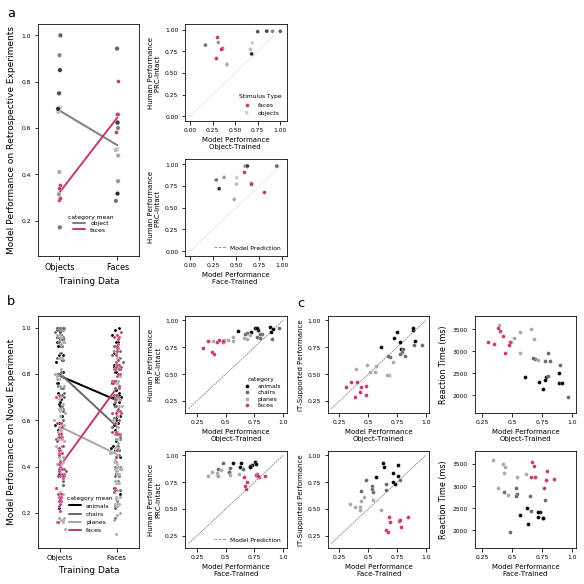

In [336]:
face_color = '#c53a73'
PARAMS = {'FACECOLOR':face_color, 'edgecolor':'white', 'pointlinewidth':.25, 'legend_title_fontsize':6, 
          'legend_fontsize':6, 's':15, 'xtick_size':6, 'ylabel_fontsize':7, 'xlabel_fontsize':7, 'labelpad':2}

label_size = 13
label_height = 1.05
label_dist = -.30

fig = plt.figure(constrained_layout=True, figsize=[8, 8])
gs = fig.add_gridspec(4, 4, wspace=0, hspace=1) 

###
ax = fig.add_subplot(gs[0:2, 0:1]); 
face_retrospective_models(PARAMS)
plt.text(label_dist, label_height-.02, 'a', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:1, 1:2]); 
face_retrospective_human(ax, PARAMS, 'prc_intact', 'fc6')
#plt.text(label_dist, label_height, 'b', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[1:2, 1:2]); 
face_retrospective_human(ax, PARAMS, 'prc_intact', 'vggface', show_legend=0)
#plt.text(label_dist, label_height, 'c', fontsize=label_size, transform=ax.transAxes,)

###
ax = fig.add_subplot(gs[2:4, 0:1]);
face_novel_model(PARAMS)
plt.text(label_dist, label_height, 'b', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[2:3, 1:2]); 
face_novel_human('imagenet', 'human', PARAMS, legend=1)
#plt.text(label_dist, label_height, 'e', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 1:2]); 
face_novel_human('vggface', 'human', PARAMS, legend=0)
#plt.text(label_dist, label_height, 'f', fontsize=label_size, transform=ax.transAxes,)

# ###
ax = fig.add_subplot(gs[2:3, 2:3]); 
face_novel_human('imagenet', 'it', PARAMS)
plt.text(label_dist, label_height+.05, 'c', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 2:3]); 
face_novel_human('vggface', 'it', PARAMS)
#plt.text(label_dist, label_height, 'h', fontsize=label_size, transform=ax.transAxes,)

ax = fig.add_subplot(gs[2:3, 3:4]); 
face_novel_human('imagenet', 'rt', PARAMS)
#plt.text(label_dist, label_height, 'i', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 3:4]); 
face_novel_human('vggface', 'rt', PARAMS)
#plt.text(label_dist, label_height, 'j', fontsize=label_size, transform=ax.transAxes,)

plt.savefig(os.path.join(_location, 'training_effects_square.pdf'), format='pdf', bbox_inches = "tight")

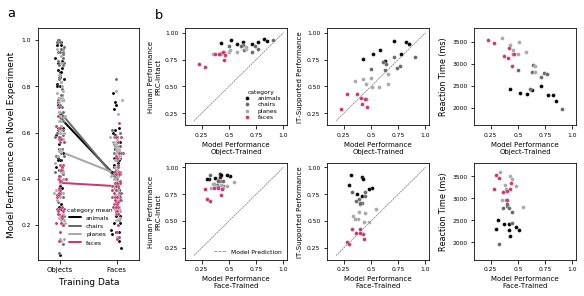

In [337]:

#face_novel_human('imagenet', 'human', PARAMS, view_type='original', legend=1)
face_color = '#c53a73'
PARAMS = {'FACECOLOR':face_color, 'edgecolor':'white', 'pointlinewidth':.25, 'legend_title_fontsize':6, 
          'legend_fontsize':6, 's':15, 'xtick_size':6, 'ylabel_fontsize':7, 'xlabel_fontsize':7, 'labelpad':2}

label_size = 13
label_height = 1.05
label_dist = -.30

fig = plt.figure(constrained_layout=True, figsize=[8, 4])
gs = fig.add_gridspec(2, 4, wspace=0, hspace=1) 

ax = fig.add_subplot(gs[0:2, 0:1]);
face_novel_model(PARAMS, view_type='original')
plt.text(label_dist, label_height, 'a', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:1, 1:2]); 
face_novel_human('imagenet', 'human', PARAMS, legend=1, view_type='original')
plt.text(label_dist, label_height+.05, 'b', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[1:2, 1:2]); 
face_novel_human('vggface', 'human', PARAMS, legend=0, view_type='original')

# ###
ax = fig.add_subplot(gs[0:1, 2:3]); 
face_novel_human('imagenet', 'it', PARAMS, view_type='original')
ax = fig.add_subplot(gs[1:2, 2:3]); 
face_novel_human('vggface', 'it', PARAMS, view_type='original')

ax = fig.add_subplot(gs[0:1, 3:4]); 
face_novel_human('imagenet', 'rt', PARAMS, view_type='original')
ax = fig.add_subplot(gs[1:2, 3:4]); 
face_novel_human('vggface', 'rt', PARAMS, view_type='original')
plt.savefig(os.path.join(_location, 'training_effects_unfoveated.pdf'), format='pdf', bbox_inches = "tight")

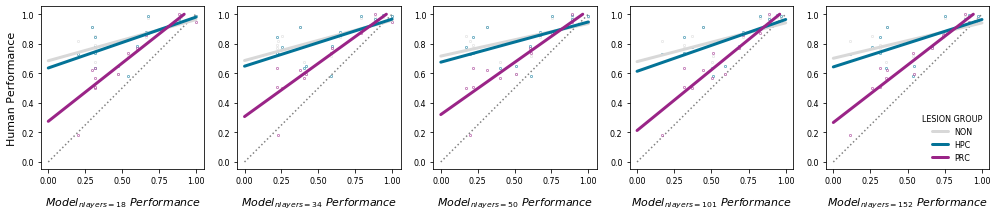

In [338]:
import colour 

def plot_nice_line(model_, params={}, title=''): 
    m, b = model_.coef_[0], model_.intercept_[0]
    xs = np.array([0, min(1 , ( ( 1 - b) / m ))])  
    plt.plot(xs, xs * m + b, **params)

lw = 3
xfs = 11
_alpha = .6
ts = 8
prc_c = '#9a2487'
hpc_c = '#037397'
con_c = '#d8d8d8'
lineparams = {'color':'','linewidth':lw,'zorder':-3, 'solid_capstyle':'round'}
dotparams = {'edgecolor':'','s':5, 'linewidth':.5,'zorder':-10, 'facecolor':'white'}

prc_ = meta_df['prc_lesion'].values
hpc_ = meta_df['hpc_lesion'].values
con_ = meta_df['prc_intact'].values

resnets = [i for i in meta_df.columns if 'resnet' in i]

plt.figure(figsize=[17, 3])

for i_resnet in range(len(resnets)): 
    
    plt.subplot(1, len(resnets), i_resnet+1)
    mod_ = meta_df[resnets[i_resnet]].values
    
    lineparams['color'],dotparams['edgecolor'] = con_c, con_c
    lineparams['label'] = 'NON'
    con_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(con_, (-1, 1)))
    plot_nice_line(con_model_, lineparams)
    plt.scatter(x=mod_, y=con_, **dotparams)
    
    lineparams['color'],dotparams['edgecolor'] = hpc_c, hpc_c
    hpc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(hpc_, (-1, 1)))
    lineparams['label'] = 'HPC'
    plot_nice_line(hpc_model_, lineparams)
    plt.scatter(x=mod_, y=hpc_,**dotparams)
    
    lineparams['color'],dotparams['edgecolor'] = prc_c, prc_c
    lineparams['label'] = 'PRC'
    prc_model_ = LinearRegression().fit(np.reshape(mod_, (-1,1)), np.reshape(prc_, (-1, 1)))
    plt.scatter(x=mod_, y=prc_, **dotparams)
    plot_nice_line(prc_model_, lineparams)

    plt.plot([0, 1], [0, 1], color='grey', linestyle=':', zorder=-15)
    plt.xlabel('$Model_{nlayers=%3d} $ $Performance$'%int(resnets[i_resnet][7:]), fontsize=xfs, labelpad=10)
    if not i_resnet: plt.ylabel('Human Performance', fontsize=xfs)
    plt.xticks(size=ts); plt.yticks(size=ts); 
    
plt.legend(framealpha=0, fontsize=8, title='LESION GROUP', title_fontsize=8)
plt.savefig(os.path.join(_location, 'resnets_panel.pdf'), bbox_inches = "tight")

KeyError: 'ylabel_fontsize'

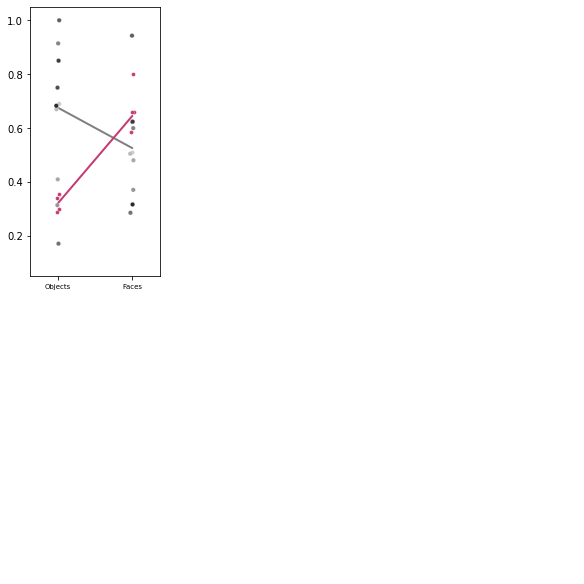

In [339]:
face_color = '#c53a73'
PARAMS = {'FACECOLOR':face_color, 'edgecolor':'white', 'pointlinewidth':.25, 'legend_title_fontsize':5, 
          'legend_fontsize':5, 's':15, 'xtick_size':5, 'xlabel_fontsize':9, 'labelpad':2}

label_size = 9
label_height = 1.03
label_dist = -.14
fig = plt.figure(constrained_layout=True, figsize=[8, 8])
gs = fig.add_gridspec(4, 4, wspace=0, hspace=1) 

###
ax = fig.add_subplot(gs[0:2, 0:1]); 
face_retrospective_models(PARAMS)
plt.text(label_dist, label_height-.02, 'a', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:1, 1:2]); 
face_retrospective_lesion(ax, PARAMS, 'prc_intact', 'fc6')
plt.text(label_dist, label_height, 'b', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[1:2, 1:2]); 
face_retrospective_lesion(ax, PARAMS, 'prc_intact', 'vggface', show_legend=0)
plt.text(label_dist, label_height, 'c', fontsize=label_size, transform=ax.transAxes,)

###
ax = fig.add_subplot(gs[2:4, 0:1]);
face_novel_model(PARAMS)
plt.text(label_dist, label_height-.02, 'd', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[2:3, 1:2]); 
face_novel_human('imagenet', 'human', PARAMS, legend=1)
plt.text(label_dist, label_height, 'e', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 1:2]); 
face_novel_human('vggface', 'human', PARAMS, legend=0)
plt.text(label_dist, label_height, 'f', fontsize=label_size, transform=ax.transAxes,)

# ###
ax = fig.add_subplot(gs[2:3, 2:3]); 
face_novel_human('imagenet', 'it', PARAMS)
plt.text(label_dist, label_height, 'g', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 2:3]); 
face_novel_human('vggface', 'it', PARAMS)
plt.text(label_dist, label_height, 'h', fontsize=label_size, transform=ax.transAxes,)

ax = fig.add_subplot(gs[2:3, 3:4]); 
face_novel_human('imagenet', 'rt', PARAMS)
plt.text(label_dist, label_height, 'i', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[3:4, 3:4]); 
face_novel_human('vggface', 'rt', PARAMS)
plt.text(label_dist, label_height, 'j', fontsize=label_size, transform=ax.transAxes,)

plt.savefig(os.path.join(_location, 'training_effects_partition.pdf'), format='pdf', bbox_inches = "tight")

In [ ]:
# def face_novel_human(i_data, y_data, PARAMS, view_type='foveated', legend=0): 
    
#     C = {'animals': '#000000','chairs': '#696969','planes': '#a8a8a8','faces': PARAMS['FACECOLOR']}
#     resolution = 'typical_name'


#     for i_category in df_select.category.unique(): 

#         i_df = df_select[df_select.category==i_category]
#         it_values = i_df[i_df.model=='it'].groupby([resolution]).mean().accuracy.values
#         v4_values = i_df[i_df.model=='v4'].groupby([resolution]).mean().accuracy.values

#         life_values = i_df[i_df.training_data=='life'].groupby([resolution]).mean().accuracy.values
#         time_values = i_df[i_df.reaction_time==i_df.reaction_time].groupby([resolution]).mean().reaction_time.values

#         i_df = i_df[i_df.image_type==view_type]
#         face_values = i_df[i_df.training_data=='vggface'].groupby([resolution]).mean().accuracy.values
#         object_values = i_df[i_df.training_data=='imagenet'].groupby([resolution]).mean().accuracy.values

#         l_fs = PARAMS['xlabel_fontsize']
#         ts = PARAMS['xtick_size']
#         s_ = PARAMS['s']
        
#         #####
#         i_set = {'it':it_values, 'imagenet':object_values, 'vggface':face_values}
#         dot_params = {'label':'$%s$'%i_category, 'facecolor':C[i_category], 
#                       's':s_, 'edgecolor':'white', 'linewidth':PARAMS['pointlinewidth']}

#         # IT
#         if y_data == 'it': 

#             plt.scatter(x=i_set[i_data], y=it_values, **dot_params)
#             plt.plot([.18, 1], [.18, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
#             plt.xlabel('$Model_{%s}$ $Performance$'%['object.trained', 'face.trained'][i_data=='vggface'], 
#                        fontsize=l_fs)
#             plt.ylabel('$IT-Supported$ $Performance$', fontsize=l_fs)
#             plt.xticks(fontsize=ts) 
#             plt.yticks(fontsize=ts)

#         # model x human accuracy
#         elif y_data == 'human': 
#             plt.scatter(x=i_set[i_data], y=life_values, **dot_params)

#             plt.plot([.18, 1], [.18, 1], color='grey', linestyle='--', linewidth=.5, alpha=.5, zorder=-2)
#             plt.xlabel('$Model_{%s}$ $Performance$'%['object.trained', 'face.trained'][i_data=='vggface'],
#                        fontsize=l_fs)
#             plt.ylabel('$Human_{prc.intact}$ $Performance$', fontsize=l_fs)
#             plt.xticks(fontsize=ts) ; plt.yticks(fontsize=ts)

#         elif y_data =='rt': 

#             x_ = i_set[i_data]
#             plt.scatter(x=x_, y=time_values, **dot_params)
#             plt.yticks(size=PARAMS['xtick_size'])
#             plt.xticks(fontsize=ts) ; plt.yticks(fontsize=ts)
#             plt.xlabel('$Model_{%s}$ $Performance$'%['object.trained', 'face.trained'][i_data=='vggface'], 
#                        fontsize=l_fs)
#             plt.ylabel('$Reaction$ $Time$ ($ms$)', fontsize=l_fs, labelpad=2)
#             plt.xticks(fontsize=ts) ; 
#             plt.yticks(fontsize=ts)
        
#         plt.xlim(.15, 1.05)
        
#     if legend: 
#         plt.legend(framealpha=0, title='$category$', loc=4, 
#                    fontsize=l_fs-2, title_fontsize=l_fs-2, labelspacing=.2,) 
        

In [ ]:
# face_color = '#c53a73'
# PARAMS = {'FACECOLOR':face_color, 'edgecolor':'white', 'pointlinewidth':.25, 'legend_title_fontsize':5, 
#           'legend_fontsize':5, 's':15, 'xtick_size':5, 'ylabel_fontsize':7, 'xlabel_fontsize':7, 'labelpad':2}

# label_size = 13
# label_height = 1.03
# label_dist = -.25
# fig = plt.figure(constrained_layout=True, figsize=[12.5, 4])
# gs = fig.add_gridspec(2, 6, wspace=0, hspace=1) 

# ###
# ax = fig.add_subplot(gs[0:2, 0:1]); 
# face_retrospective_models(PARAMS)
# plt.text(label_dist, label_height-.02, 'a', fontsize=label_size, transform=ax.transAxes,)
# ###
# ax = fig.add_subplot(gs[0:1, 1:2]); 
# face_retrospective_human(ax, PARAMS, 'prc_intact', 'fc6')
# #plt.text(label_dist, label_height, 'b', fontsize=label_size, transform=ax.transAxes,)
# ax = fig.add_subplot(gs[1:2, 1:2]); 
# face_retrospective_human(ax, PARAMS, 'prc_intact', 'vggface', show_legend=0)
# #plt.text(label_dist, label_height, 'c', fontsize=label_size, transform=ax.transAxes,)

# ###
# ax = fig.add_subplot(gs[0:2, 2:3]);
# face_novel_model(PARAMS)
# plt.text(label_dist, label_height-.02, 'b', fontsize=label_size, transform=ax.transAxes,)

# # pos1 = ax.get_position() # get the original position 
# # pos2 = [pos1.x0 + 0.3, pos1.y0,  pos1.width , pos1.height ] 
# # ax.set_position(pos2) # set a new position

# ###
# ax = fig.add_subplot(gs[0:1, 3:4]); 
# face_novel_human('imagenet', 'human', PARAMS, legend=1)
# #plt.text(label_dist, label_height, 'e', fontsize=label_size, transform=ax.transAxes,)
# ax = fig.add_subplot(gs[1:2, 3:4]); 
# face_novel_human('vggface', 'human', PARAMS, legend=0)
# #plt.text(label_dist, label_height, 'f', fontsize=label_size, transform=ax.transAxes,)



# # ###
# ax = fig.add_subplot(gs[0:1, 4:5]); 
# face_novel_human('imagenet', 'it', PARAMS)
# plt.text(label_dist, label_height, 'c', fontsize=label_size, transform=ax.transAxes,)
# ax = fig.add_subplot(gs[0:1, 5:6]); 
# face_novel_human('imagenet', 'rt', PARAMS)
# #plt.text(label_dist, label_height, 'i', fontsize=label_size, transform=ax.transAxes,)

# ax = fig.add_subplot(gs[1:2, 4:5]); 
# face_novel_human('vggface', 'it', PARAMS)
# #plt.text(label_dist, label_height, 'h', fontsize=label_size, transform=ax.transAxes,)
# ax = fig.add_subplot(gs[1:2, 5:6]); 
# face_novel_human('vggface', 'rt', PARAMS)
# #plt.text(label_dist, label_height, 'j', fontsize=label_size, transform=ax.transAxes,)

# plt.savefig(os.path.join(_location, 'training_effects.pdf'), format='pdf', bbox_inches = "tight")

In [ ]:
# def face_retrospective_models(PARAMS): 
#     np.random.seed(1234)
#     con_color =  ('#2a2a2a', '#cccccc')
#     n_objects = sum(['face' not in i for i in meta_df.experiment])
#     c_objects = [i.rgb for i in colour.Color(con_color[1]).range_to(colour.Color(con_color[0]), n_objects)]
#     c_faces = PARAMS['FACECOLOR']
#     s_ = PARAMS['s']+10
#     x0 = .1
#     x1 = .9
#     xticks = PARAMS['xtick_size']+2
#     lw = PARAMS['pointlinewidth']+.25
#     _params = {'edgecolor':PARAMS['edgecolor'], 's':s_, 'linewidth':lw}
    
#     i_df = meta_df[ ['face' in i for i in meta_df.experiment] ] 
#     plt.scatter(x=[x1+np.random.randn()/100 for i in range(len(i_df))],y=i_df['vggface'],facecolor=c_faces, **_params)
#     plt.scatter(x=[x0+np.random.randn()/100 for i in range(len(i_df))],y=i_df['fc6'],facecolor=c_faces, **_params)
#     faces_ = [i_df['vggface'].mean(), i_df['fc6'].mean()]

#     _params = {'edgecolor':'white', 's':s_, 'linewidth':lw, 'zorder':-2}
#     i_df = meta_df[ ['face' not in i for i in meta_df.experiment] ] 
#     plt.scatter(x=[x1+np.random.randn()/100 for i in range(len(i_df))],y=i_df['vggface'],facecolor=c_objects, **_params)
#     plt.scatter(x=[x0+np.random.randn()/100 for i in range(len(i_df))],y=i_df['fc6'],facecolor=c_objects, **_params)
#     objects_ = [i_df['vggface'].mean(), i_df['fc6'].mean()]

#     _params = {'linewidth':2, 'zorder':-5, 'linestyle':'-', 'alpha':1, 'solid_capstyle':'round'}
#     plt.plot([x0, x1], [faces_[0], objects_[0]], color='grey', **_params, label='$object$') 
#     plt.plot([x0, x1], [faces_[1], objects_[1]], color=c_faces, **_params, label='$faces$')
#     plt.xlim(-.2, 1.2)
#     #plt.ylim(.01, 1.15)
#     plt.ylim([-0.01, 1.1])
#     plt.xticks([x0, x1], ['$objects_{imagenet}$', '$faces_{vggface2}$'], fontsize=xticks, y=0,)
#     plt.ylabel('$Model$ $Performance$ $on$ $Retrospective$ $Experiments$', labelpad=2, 
#                fontsize=PARAMS['xlabel_fontsize']); 
#     plt.yticks(fontsize=xticks)
#     plt.xlabel('$Training$ $Data$', labelpad=2, fontsize=PARAMS['xlabel_fontsize'])
#     plt.legend(title='$category$ $mean$', framealpha=0, fontsize=PARAMS['legend_fontsize']+2, 
#                labelspacing=.2, loc=8, title_fontsize=PARAMS['legend_title_fontsize']+2)

In [ ]:
face_color = '#c53a73'
PARAMS = {'FACECOLOR':face_color, 'edgecolor':'white', 'pointlinewidth':.25, 'legend_title_fontsize':5, 
          'legend_fontsize':5, 's':15, 'xtick_size':5, 'xlabel_fontsize':9, 'labelpad':2}

label_size = 9
label_height = 1.03
label_dist = -.14
fig = plt.figure(constrained_layout=True, figsize=[12, 4])
gs = fig.add_gridspec(4, 12, wspace=0, hspace=1) 
###
ax = fig.add_subplot(gs[0:4, 0:2]); 
face_retrospective_models(PARAMS)
plt.text(label_dist, label_height-.02, 'a', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:2, 2:4]); 
face_retrospective_lesion(ax, PARAMS, 'prc_intact', 'fc6')
plt.text(label_dist, label_height, 'b', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[2:4, 2:4]); 
face_retrospective_lesion(ax, PARAMS, 'prc_intact', 'vggface')
plt.text(label_dist, label_height, 'c', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:4, 4:6]);
face_novel_model(PARAMS)
plt.text(label_dist, label_height-.02, 'd', fontsize=label_size, transform=ax.transAxes,)
###
ax = fig.add_subplot(gs[0:2, 6:8]); 
face_novel_human('imagenet', 'human', PARAMS, legend=1)
plt.text(label_dist, label_height, 'e', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[0:2, 8:10]); 
face_novel_human('imagenet', 'it', PARAMS)
plt.text(label_dist, label_height, 'g', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[0:2, 10:12]); 
face_novel_human('imagenet', 'rt', PARAMS)
plt.text(label_dist, label_height, 'i', fontsize=label_size, transform=ax.transAxes,)

###
ax = fig.add_subplot(gs[2:4, 6:8]); 
face_novel_human('vggface', 'human', PARAMS, legend=1)
plt.text(label_dist, label_height, 'f', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[2:4, 8:10]); 
face_novel_human('vggface', 'it', PARAMS)
plt.text(label_dist, label_height, 'h', fontsize=label_size, transform=ax.transAxes,)
ax = fig.add_subplot(gs[2:4, 10:12]); 
face_novel_human('vggface', 'rt', PARAMS)
plt.text(label_dist, label_height, 'j', fontsize=label_size, transform=ax.transAxes,)

plt.tight_layout()
plt.savefig(os.path.join(_location, 'training_effects_horizontal.pdf'), format='pdf', bbox_inches = "tight")